# Fitting to short-term re-emigration data
To represent the emigration behaviour of recent immigrants, we need to extract emigration 'survival curves', stratified by entry year, visa category and country of origin. Since the data is limited in time range (among other limitations), we need to fit models to the available data which will allow us to extrapolate emigration behaviour into the future. The current simplifying assumption is that the age and sex dependencies are constant over time.   

## Theory 
On entry, immigrants are defined as remaining indefinitely with probability, $p$. For those not remaining indefinitely, a survival curve can be defined of not emigrating each year. We examine an exponential and a logistic survival curve. 

For each combination of visa type, country and entry year, the data comprises a sequence of annual observations of numbers immigrants still in the country (that is, with valid visas). We can represent the data as $\{I_0,I_1,\ldots,I_N\}$; $I_0$ is the initial influx in the entry year and $I_j$ is the number with valid visas after $j$ years. The range of data will depend on the entry year and the range of available data. The number emigrating in the $j^{th}$ year is 
$$ \Delta I_j = I_j - I_{j+1};\quad 0 \le j < N.  $$
We can define a probability for emigrating in each year category $p_j; 0\le j\le N-1$ and also a probability for not emigrating within the years observed, $p_N$ can be defined. The distribution of $\Delta I_0, \Delta I_1, \ldots, I_N$ will be multinomially distributed and the likelihood can be easily calculated.  

## Exponential model
The exponential model of re-emigration considers only two processes. On entry, immigrants are defined as remaining indefinitely with probability, $p$. For those not remaining indefinitely, there is a probability $q$ of not emigrating each year. This results in the number of immigrants decaying exponentially over time from the initial number to the number remaining indefinitely, which approximately matches the shape of the re-emigration 'survival curves'. 

The probability that an immigrant re-emigrates in the year 0 is $(1-p)(1-q)$. The probability of emigrating in the $j^{th}$ year is $p_j = (1-p)q^j(1-q)$. The probability that an individual is still here in year $N$ is $p_N = p+(1-p)q^N$. Hence the dataset $\mathcal{D} = \{\Delta I_0, \Delta I_1,\ldots,\Delta I_{N-1},I_N\}$ is distributed as a multinomial with probability vector, $\mathbf{p} = \{p_0, p_1, \ldots, p_{N-1}, p_N\}$ (this sounds plausible and is also easily provable). We can write the log-likelihood as
$$ \mathcal{L} = \mbox{Const} + \sum^{N-1}_{i=0} D_i\ln p_i + I_n \ln p_N $$

The MLE parameter values can be found by considering 
$$ \frac{\partial}{\partial p}  \mathcal{L} = \frac{\partial}{\partial q}  \mathcal{L} = 0$$. 

The first of these gives a relationship between $p$ and $q$. 
$$ p(q) = 1 - \frac{I_0 - I_N}{I_0(1-q^N)} $$

Note that $dp/dq < 0$, $p(0) = I_N/I_0$ and $p(q_{max})=0$, where $q_{max} = \sqrt[N]{I_N/I_0}$. The MLE can be found be searching for the root 
$$ \frac{\partial}{\partial q}  \mathcal{L}(p(q_0),q_0) = 0; \quad 0 < q_0 < q_{max} $$ 

giving the MLE $(p(q_0),q_0)$. 

In [1]:
# Setup...
import numpy as np
import pandas as pd
from scipy import optimize
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import emcee
import pickle

encPath = '..\\SharedFiles\\'


# The current encoding.
Encoding = '4visa'
encodingFileName = encPath + f'DefEncoding_{Encoding}.p'
pickle_input = open(encodingFileName, 'rb')
country2Index_dict, sexes, defVisaCats, Visa2Index_dict, visaSet, \
    EDetTB2VisaCats, regionSet = pickle.load(pickle_input)

In [2]:
# Define the functions...

def getP(q_value, NS_dict):
    '''
    Calculate the value of parameter p as a function of q.
    Uses the dL/dp = 0 constraint. 
    takes value for q, and dictionary of necessary stats. 
    '''
    I_ratio = (NS_dict['I0'] - NS_dict['IN'])/NS_dict['I0']
    return 1 - I_ratio/(1 - q_value**NS_dict['N'])


def getdLdq(p_value, q_value, NS):
    '''
    Calculate the value of dl/dq for values of q and p(q). 
    '''
    out_value = -(NS['I0'] - NS['IN'])/(1-q_value) + NS['J']/q_value
    q_N = q_value**NS['N']
    out_value += NS['IN']*NS['N']*(1-p_value)*q_N/(q_value*(p_value+(1-p_value)*q_N))
    return out_value


def getdLdq_2(q_value, NS):
    '''
    Calculate the value of dl/dq for values of q and p(q). 
    '''
    p_value = getP(q_value, NS)
    out_value = -(NS['I0'] - NS['IN'])/(1-q_value) + NS['J']/q_value
    q_N = q_value**NS['N']
    out_value += NS['IN']*NS['N']*(1-p_value)*q_N/(q_value*(p_value+(1-p_value)*q_N))
    return out_value


# Function to take a country and an entry year. 
# Return a dataframe of MLE fit against data. 
def getFit_df(country, visaType, entry_year): 
    '''
    Calculate the MLE parameters and generate a DF comparing theory and data for MLE. 
    Takes: country, visa and entry year. 
    Returns: (comparison DF, MLE dict) 
    Assumes: global variable, raw_data with MJ data in it. 
    '''
    # Filter out the country and entry year.
    c_Filter = raw_data['nationality'].isin([country]) 
    eY_Filter = raw_data['year_issued'].isin([2005])
    v_Filter = raw_data['visa_cat_broad'].isin([visaType])
    f_Filter = c_Filter.values & eY_Filter.values & v_Filter.values

    C_EY_V_Data = raw_data[f_Filter]

    lData = C_EY_V_Data.shape[0]
    ImmDataset = C_EY_V_Data['ImmYrStart'].values

    # Necessary statistics.
    del_I = -np.diff(ImmDataset)
    indices = np.array(range(len(del_I)))
    NecStat_dict = {
        'I0': ImmDataset[0], 
        'IN': ImmDataset[lData-1], 
        'J': np.sum(indices*del_I), 
        'N': lData - 1  # should be index of last element. 
    }

    q_max = np.power(NecStat_dict['IN']/NecStat_dict['I0'], 1.0/NecStat_dict['N'])
    q_min = 0.00001  # a tiny magic number. 
    output = optimize.bisect(getdLdq_2, q_min, q_max, args=(NecStat_dict,))

    q_ans = output
    p_ans = getP(q_ans, NecStat_dict)

    # calculate MLE mean output.
    multiProbs = [(1-p_ans)*(1-q_ans)*q_ans**i for i in range(NecStat_dict['N'])]
    p_n = p_ans + (1-p_ans)*q_ans**NecStat_dict['N']
    multiProbs += [p_n]

    ExpValues = np.array(multiProbs)*NecStat_dict['I0']
    totals = np.cumsum(ExpValues[::-1])[::-1]

    plot_dict = {  
        'Theory': totals, 
        'Data': ImmDataset,
        'Year': C_EY_V_Data['yearIndex'].values
        }

    MLE_dict = {
        'p': p_ans, 
        'q': q_ans
        }

    plot_df = pd.DataFrame(plot_dict)
    # return the best fit fig data and MLE params 
    return (plot_df, MLE_dict)


# Function to return likelihood from parameter values and data.
# The logistic model.
def getLogisticLL(params, d_dict):
    '''
    Takes:
    params = {p, k, delta}
    d_dict: dictionary of relevant bits of data. 
    Returns: log-likelihood. 
    '''
    # Parameters. 
    p = params[0]
    k = params[1]
    delta = params[2] 

    if p*(1-p) < 0.0001:  # This was 0, but I caught p = 0.0 occuring. 
        return -np.inf  # keep 0 < p < 1. 

    if k < 0.0001:  # v small values were causing zero problems.
        return -np.inf  # Don't let the tanh curve 'flip'.

    if delta < -1.5:
        return -np.inf  # delta too negative gets into shift/scaling invariance. 

    # Survival curve details. 
    N = len(d_dict['dI'])+1
    S_values = [0.5*(1-np.tanh(k*(i-delta)/2)) for i in range(N)]
    d_S = -np.diff(S_values)

    # Debugging:
    # if any(d_S <= 0.0001):
    #    return -np.inf

    # Calculate the log-likelihood.
    fn_value = (d_dict['I0']-d_dict['IN'])*np.log((1-p)/S_values[0])
    fn_value += np.sum(d_dict['dI']*np.log(d_S)) 
    fn_value += d_dict['IN']*np.log(p + (1-p)*S_values[N-1]/S_values[0])

    if np.isnan(fn_value):
        fn_value = -np.inf

    return fn_value


# Function to fit the logistic survival model.
def getLogisticFit(country, visaType, entry_year): 
    '''
    Fits the logistic survival curve model. 
    Takes the country visa type and entry year. 
    Returns (mean data for comparison, MLE values). 
    Assumes data is in raw_data global variable. 
    '''
    # Filter out the country and entry year. 
    c_Filter = raw_data['nationality'].isin([country]) 
    eY_Filter = raw_data['year_issued'].isin([entry_year])
    v_Filter = raw_data['visa_cat_broad'].isin([visaType])
    f_Filter = c_Filter.values & eY_Filter.values & v_Filter.values

    C_EY_V_Data = raw_data[f_Filter]

    lData = C_EY_V_Data.shape[0]
    ImmDataset = C_EY_V_Data['ImmYrStart'].values

    # Necessary statistics. 
    del_I = -np.diff(ImmDataset)

    # data dictionary.
    logisticModel_dict = {
        'dI': del_I,
        'I0': ImmDataset[0],
        'IN': ImmDataset[lData-1]
    }

    # generally stable IC... 
    initial = np.array([0.5, 0.8, 3.0])
    func = lambda x: -getLogisticLL(x, logisticModel_dict)
    # Nelder-Mead seems stable. 
    soln = minimize(func, initial, method='Nelder-Mead')

    # Construct the MLE mean behaviour. 
    p = soln.x[0]
    k = soln.x[1]
    delta = soln.x[2]
    MLE_S_values = [0.5*(1-np.tanh(k*(i-delta)/2)) \
                    for i in range(len(logisticModel_dict['dI'])+1)]

    I_expected = p + (1-p)*np.array(MLE_S_values)/MLE_S_values[0]
    I_expected *= logisticModel_dict['I0']

    plot_dict = {  
        'Theory': I_expected, 
        'Data': ImmDataset,
        'Year': C_EY_V_Data['yearIndex'],
        'Country': C_EY_V_Data['nationality'], 
        'YearIssued': C_EY_V_Data['year_issued'],
        'Visa': C_EY_V_Data['visa_cat_broad']
    }

    plot_df = pd.DataFrame(plot_dict)

    # returns data for model MLE project projection into data space,
    # MLE parameters and the data dictionary for calling getLogisticLL(...)
    return (plot_df, soln.x, logisticModel_dict)


# Function to fit the logistic survival model. 
def getLogisticFit_prior(country, visaType, entry_year): 
    '''
    Fits the logistic survival curve model. 
    Takes the country visa type and entry year. 
    Returns (mean data for comparison, MLE values). 
    Assumes data is in raw_data global variable. 
    '''
    # Filter out the country and entry year. 
    c_Filter = raw_data['nationality'].isin([country])
    eY_Filter = raw_data['year_issued'].isin([entry_year])
    v_Filter = raw_data['visa_cat_broad'].isin([visaType])
    f_Filter = c_Filter.values & eY_Filter.values & v_Filter.values

    C_EY_V_Data = raw_data[f_Filter]

    lData = C_EY_V_Data.shape[0]
    ImmDataset = C_EY_V_Data['ImmYrStart'].values

    # Necessary statistics. 
    del_I = -np.diff(ImmDataset)

    # data dictionary. 
    logisticModel_dict = {
        'dI': del_I, 
        'I0': ImmDataset[0], 
        'IN': ImmDataset[lData-1] 
    }

    # generally stable IC... 
    initial = np.array([0.5, 0.8, 3.0])
    # prior. linear as log. 
    q = 50
    func = lambda x: -(getLogisticLL(x, logisticModel_dict)+q*x[0])
    # Nelder-Mead seems stable. 
    soln = minimize(func, initial, method='Nelder-Mead')

    # Construct the MLE mean behaviour.
    p = soln.x[0]
    k = soln.x[1]
    delta = soln.x[2]
    MLE_S_values = [0.5*(1-np.tanh(k*(i-delta)/2)) \
                for i in range(len(logisticModel_dict['dI'])+1)]

    I_expected = p + (1-p)*np.array(MLE_S_values)/MLE_S_values[0]
    I_expected *= logisticModel_dict['I0']

    plot_dict = {
        'Theory': I_expected, 
        'Data': ImmDataset,
        # 'Year': np.array(range(len(ImmDataset))),
        'Year': C_EY_V_Data['yearIndex'],
        'Country': C_EY_V_Data['nationality'], 
        'YearIssued': C_EY_V_Data['year_issued'],
        'Visa': C_EY_V_Data['visa_cat_broad']
    }

    plot_df = pd.DataFrame(plot_dict)

    # returns data for model MLE project projection into data space, 
    # MLE parameters and the data dictionary for calling getLogisticLL(...)
    return (plot_df, soln.x, logisticModel_dict)


# Function to fit the logistic survival model. 
def getParamUncertainty(country, visaType, entry_year, MLE_params): 
    '''
    Assumes data is in raw_data global variable.
    '''
    # Filter out the country and entry year.
    c_Filter = raw_data['nationality'].isin([country]) 
    eY_Filter = raw_data['year_issued'].isin([entry_year])
    v_Filter = raw_data['visa_cat_broad'].isin([visaType])
    f_Filter = c_Filter.values & eY_Filter.values & v_Filter.values

    C_EY_V_Data = raw_data[f_Filter]

    lData = C_EY_V_Data.shape[0]
    ImmDataset = C_EY_V_Data['ImmYrStart'].values

    # Necessary statistics. 
    del_I = -np.diff(ImmDataset)

    # data dictionary. 
    logisticModel_dict = {
        'dI': del_I, 
        'I0': ImmDataset[0], 
        'IN': ImmDataset[lData-1] 
    }

    # Get the uncertainties for the parameters. 
    nWalkers = 10
    ndim = len(MLE_params) 

    pos = MLE_params + 0.01 * np.random.randn(nWalkers, ndim)

    sampler = emcee.EnsembleSampler(nWalkers, ndim, getLogisticLL, args=(logisticModel_dict, ))
    sampler.run_mcmc(pos, 500)  # was 10000

    flat_samples = sampler.get_chain(discard=100, thin=10, flat=True)
    param_95CI = np.quantile(flat_samples, [0.025, 0.975], axis=0)

    # returns data for model MLE project projection into data space,
    # MLE parameters and the data dictionary for calling getLogisticLL(...)
    return (logisticModel_dict, param_95CI)


# a function to take data in the 'Laura' format, like migrant_journey_updatedSep21_d.csv, 
# and convert it to the MJ_dataForIBM_V3.txt format. 
# This format isn't used by the IBM anymore, but the fitting code was based on it. 
# That file has the format: 
# nationality, countryIndex, year_issued, yearIssuedIndex, visa_cat_broad, visaIndex, year, yearIndex, ImmYrStart
# REQUIRES correct encoding dictionaries to be in place from the pickle file, DefEncoding_XXXX.p
def laura2MJformat(laura_data):
    '''
    a function to take data in the 'Laura' format, like migrant_journey_updatedSep21_d.csv, 
    and convert it to the MJ_dataForIBM_V3.txt format. 
    This format isn't used by the IBM anymore, but the fitting code was based on it. 
    That file has the format: 
    nationality, countryIndex, year_issued, yearIssuedIndex, visa_cat_broad, visaIndex, year, yearIndex, ImmYrStart
    REQUIRES correct encoding dictionaries to be in place from the pickle file, DefEncoding_XXXX.p
    '''
    # We want valid at the end of year to be quantity at the start of next year.
    colNames = list(laura_data.columns)
    laura_data['year2'] = laura_data['year'].values+1
    validFilter = laura_data['status_year_end'].isin(['Valid visa'])
    newData2 = laura_data[validFilter]

    # Need to add entries for cases where year_issued == year. We assume that at the start 
    # of those years, they have valid visa + expired at the start of the year...
    entryYearFilter = laura_data['year_issued'] == laura_data['year']
    entryYearData = laura_data[entryYearFilter]

    grouped = entryYearData.groupby(colNames[:3])
    validExpTotal = grouped['value'].agg(np.sum) 

    # now reconstruct a dataframe.
    total_data = [list(i) + [i[1], 'FakeStatus', v, i[1]] for i, v in validExpTotal.iteritems()]
    total_df = pd.DataFrame(total_data).copy()
    total_df.columns = newData2.columns

    final_df = pd.concat([newData2, total_df], axis=0)
    final_df = final_df.drop(['status_year_end', 'year'], axis=1)
    final_df.rename(columns={'year2': 'year', 'value': 'ImmYrStart'}, inplace=True)

    # Add extra columns and clean up...
    final_df['countryIndex'] = [country2Index_dict[x] for x in final_df['nationality'].values]
    final_df['visaIndex'] = [Visa2Index_dict[x] for x in final_df['visa_cat_broad'].values]
    final_df['yearIssuedIndex'] = final_df['year_issued'].values - np.min(final_df['year_issued'].values)
    final_df['yearIndex'] = final_df['year'].values - final_df['year_issued'].values

    final_cols = ['nationality', 'countryIndex', 'year_issued', 'yearIssuedIndex',
                  'visa_cat_broad', 'visaIndex', 'year', 'yearIndex', 'ImmYrStart']

    final_df = final_df[final_cols]
    final_df.sort_values(by=['nationality', 'visaIndex', 'year_issued', 'year'], inplace=True)
    return final_df

In [3]:
# Read in the data. 
fileName = 'migrant_journey_updatedSep21_e.csv'
laura_data = pd.read_csv(fileName, comment='#')

colNames = list(laura_data.columns)


# summary...
summary = [[x] + [np.unique(laura_data[x])] for x in colNames]
print(summary)

# Convert to required format. 
raw_data = laura2MJformat(laura_data) 

visaTypes = list(np.unique(raw_data['visa_cat_broad']))

[['nationality', array(['Bangladesh', 'China', 'India', 'Pakistan', 'Sub_Saharan_Africa'],
      dtype=object)], ['year_issued', array([2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014,
       2015, 2016, 2017, 2018, 2019, 2020], dtype=int64)], ['visa_cat_broad', array(['Dep_J_A', 'Family', 'Study', 'Work'], dtype=object)], ['year', array([2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014,
       2015, 2016, 2017, 2018, 2019, 2020], dtype=int64)], ['status_year_end', array(['Expired', 'Valid visa'], dtype=object)], ['value', array([    0,     1,     2, ..., 71330, 76854, 87994], dtype=int64)]]


## Exponential model: results
Results below indicate that the model captures the broad shape of the data (the descent to a plateau value), but fails to reproduce some features that are common to most datasets, to a varying degree. In most cases, the loss to re-emigration is starts later and happens quicker than the fitted model suggests.  

A better model might include an initial period of lower emigration rate or perhaps a logistic shape for the re-emigration. 

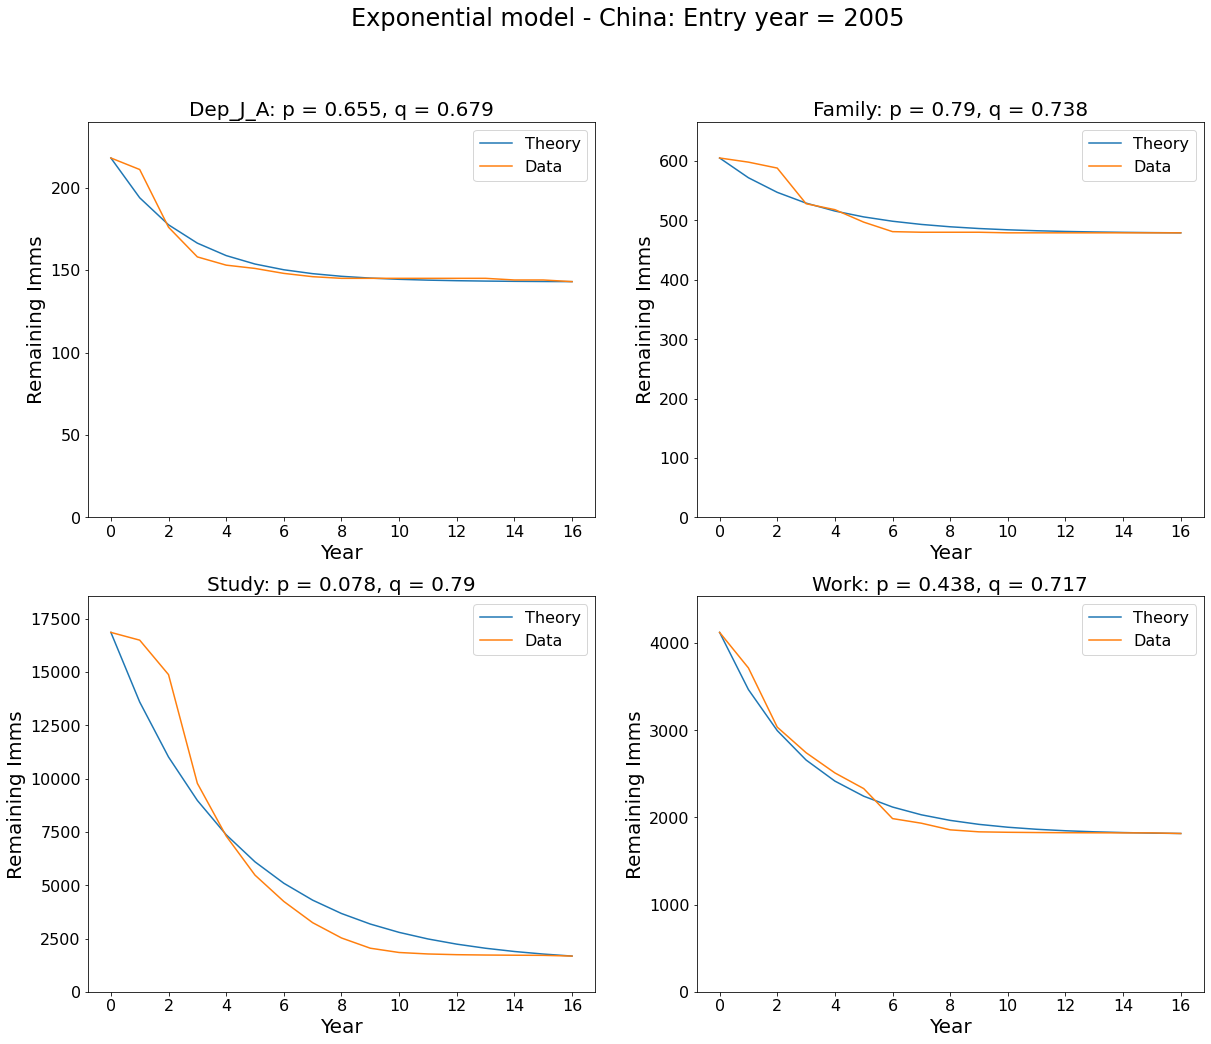

In [4]:
# Draw a figure... 

country = 'China'
entryYear = 2005

fig, ax = plt.subplots(ncols=2, nrows=2)

for i in range(len(visaTypes)):
    i_row = i // 2
    i_col = i % 2
    currentVisa = visaTypes[i]
    plot_data, MLE_params = getFit_df(country, currentVisa, entryYear)
    currentAx = ax[i_row, i_col]
    plot_data.plot.line(x='Year', ax=currentAx)
    currentAx.set_ylim(0, max(plot_data['Data'])*1.1)
    plot_title = visaTypes[i] + ': p = ' + str(np.around(MLE_params['p'],3)) + ', q = ' + str(np.around(MLE_params['q'],3))
    currentAx.set_title(plot_title, fontsize=20)
    currentAx.set_ylabel('Remaining Imms', fontsize=20)
    currentAx.set_xlabel(xlabel='Year', fontsize=20)
    currentAx.tick_params(axis='both', which='major', labelsize=16)
    currentAx.legend(fontsize=16)


fig.set_size_inches(20, 16)
# fig.subplots_adjust(top=0.8)
fig.suptitle(f'Exponential model - {country}: Entry year = {entryYear}', fontsize=24)
# fig.tight_layout()
plt.show()

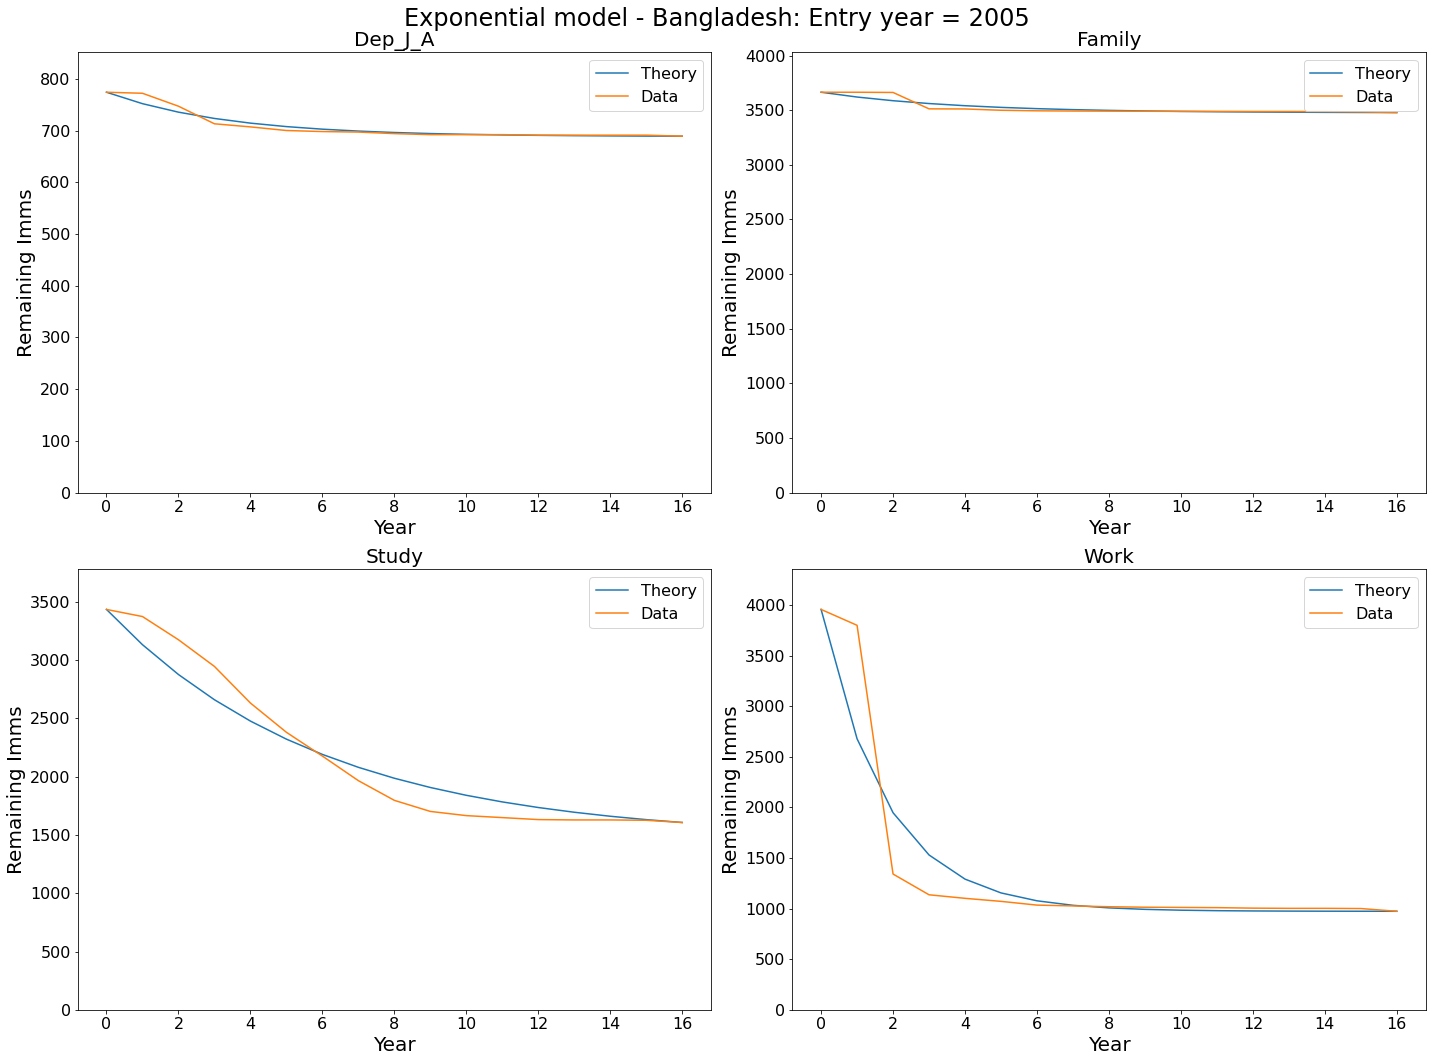

In [5]:
# Draw a figure... 

country = 'Bangladesh'
entryYear = 2005

fig, ax = plt.subplots(ncols=2, nrows=2)

for i in range(len(visaTypes)):
    i_row = i // 2
    i_col = i % 2
    currentVisa = visaTypes[i]
    plot_data, MLE = getFit_df(country, currentVisa, entryYear)
    currentAx = ax[i_row, i_col]
    plot_data.plot.line(x='Year', ax=currentAx)
    currentAx.set_ylim(0, max(plot_data['Data'])*1.1)
    currentAx.set_title(visaTypes[i], fontsize=20)
    currentAx.set_ylabel('Remaining Imms', fontsize=20)
    currentAx.set_xlabel(xlabel='Year', fontsize=20)
    currentAx.tick_params(axis='both', which='major', labelsize=16)
    currentAx.legend(fontsize=16)


fig.set_size_inches(20, 15)
fig.suptitle(f'Exponential model - {country}: Entry year = {entryYear}', fontsize=24)
fig.tight_layout()
plt.show()

## Logistic model
This model is less mechanistic and uses a logistic form for the survival against re-emigration curve. The survival function is logistic:
$$ \sigma_i = \frac{1}{2}\left[1 - \tanh\left(\frac{k(i-\delta)}{2}\right)\right]$$ 
for integer $i$ where $i$ is the year (entry at year 0). The gradient parameter is constrained $k>0$ to avoid a 'flip' of the function. Additionally, we still have probability of settling permamently, $p$, that was in the exponential model. We also constrain the offset $\delta > Q$, where $Q$ is adjustable, but around -1.5. This is necessary as for large $x$, the $1-\tanh(x) \approx \exp(-2x)$ function. Since the survival curve is scaled by $S_0$, for large $x$ changes in $\delta$ will be scaled out, leaving any fitting algorithm flailing.  So the overall survival probability for an individual to the start of year $i$ is given by
$$ S_i = p + (1+p)\frac{\sigma_i}{\sigma_0} $$

The structure of the model is still multinomial from the survival curve, but the probabilities in the likelihood are now defined differently 
$$ p_i = \frac{(1-p)}{\sigma_0}(\sigma_i-\sigma_{i+1})$$ 
and
$$ p_N = p + (1-p)\frac{\sigma_N}{\sigma_0} $$

THis is now a 3-parameter problem and the derivatives of $\mathcal{L}$ are no longer tractable, so an optimization routine is necessary to find the MLE values. The Nelder-Mead algorithm seems to be fairly stable, whereas other approaches seem to fail. 

## Logistic model: results
This clearly works a lot better. All the fits below are based on large datasets, but the fits are good across these countries and visa types. 


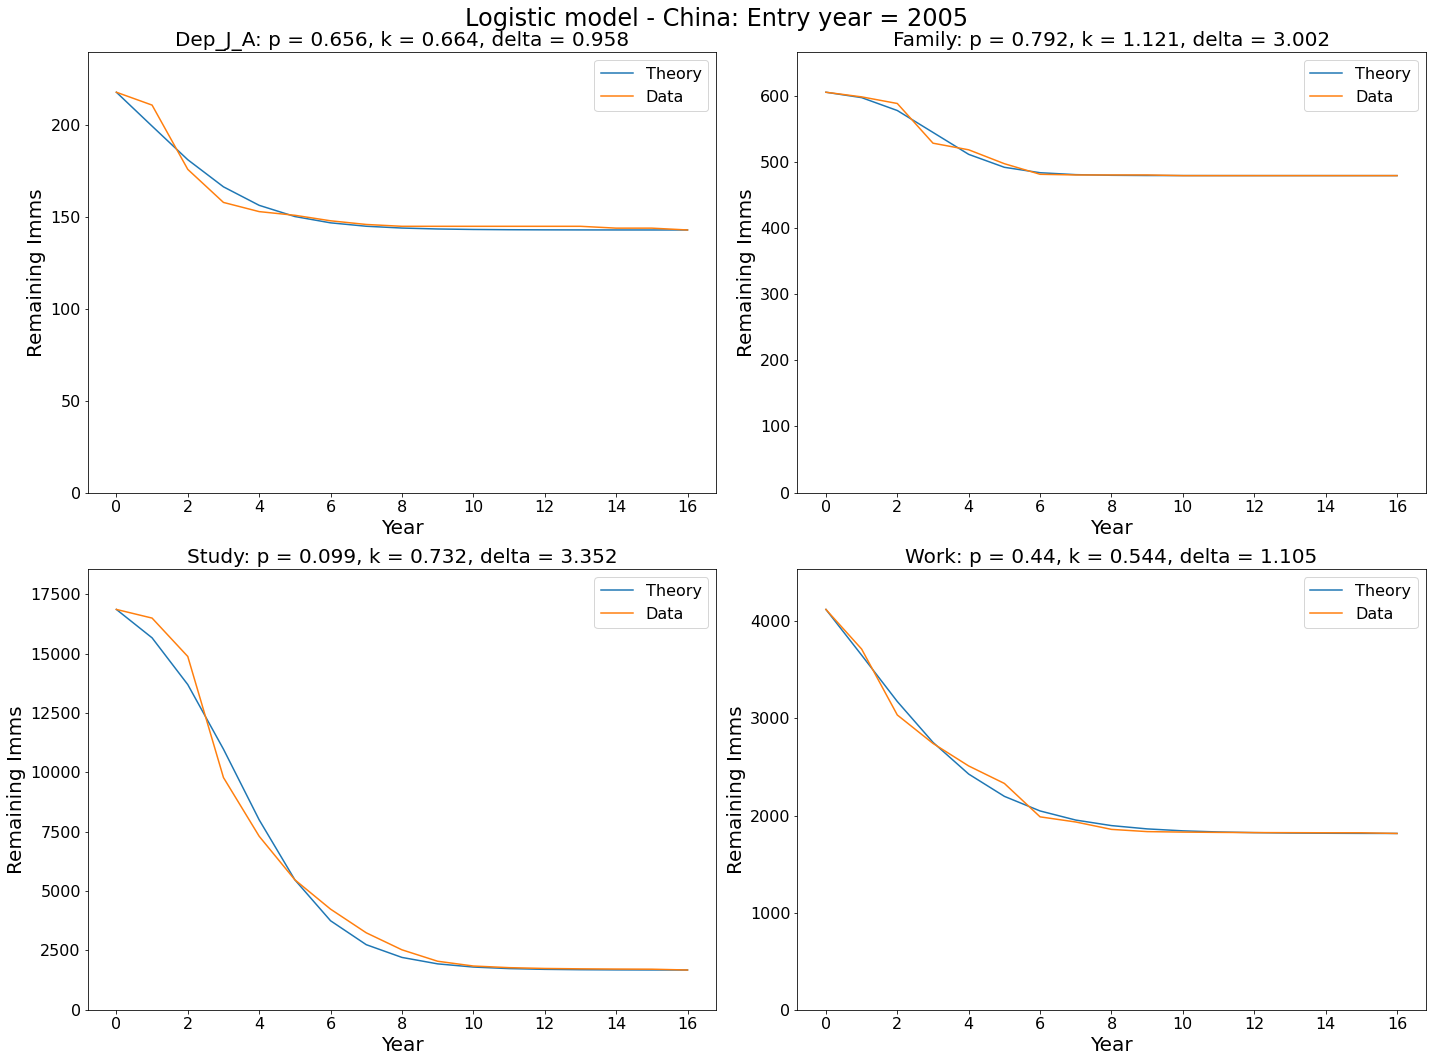

In [6]:
# Fit and draw results from the logistic model. 
# import matplotlib.pyplot as plt

country = 'China'
entryYear = 2005

fig, ax = plt.subplots(ncols=2, nrows=2) 

for i in range(len(visaTypes)):
    i_row = i // 2
    i_col = i % 2
    currentVisa = visaTypes[i]
    plot_data, MLE_params, d_dict = getLogisticFit(country, currentVisa, entryYear)
    currentAx = ax[i_row, i_col]
    plot_data.plot.line(x='Year', y=['Theory', 'Data'], ax=currentAx) 
    currentAx.set_ylim(0, max(plot_data['Data'])*1.1)
    plot_title = visaTypes[i] + ': p = ' + str(np.around(MLE_params[0],3)) + ', k = ' + str(np.around(MLE_params[1],3))  + ', delta = ' + str(np.around(MLE_params[2],3))
    currentAx.set_title(plot_title, fontsize=20)
    currentAx.set_ylabel('Remaining Imms', fontsize=20)
    currentAx.set_xlabel(xlabel='Year', fontsize=20)
    currentAx.tick_params(axis='both', which='major', labelsize=16)
    currentAx.legend(fontsize=16)


fig.set_size_inches(20, 15)
fig.suptitle(f'Logistic model - {country}: Entry year = {entryYear}', fontsize=24)
fig.tight_layout()
plt.show()

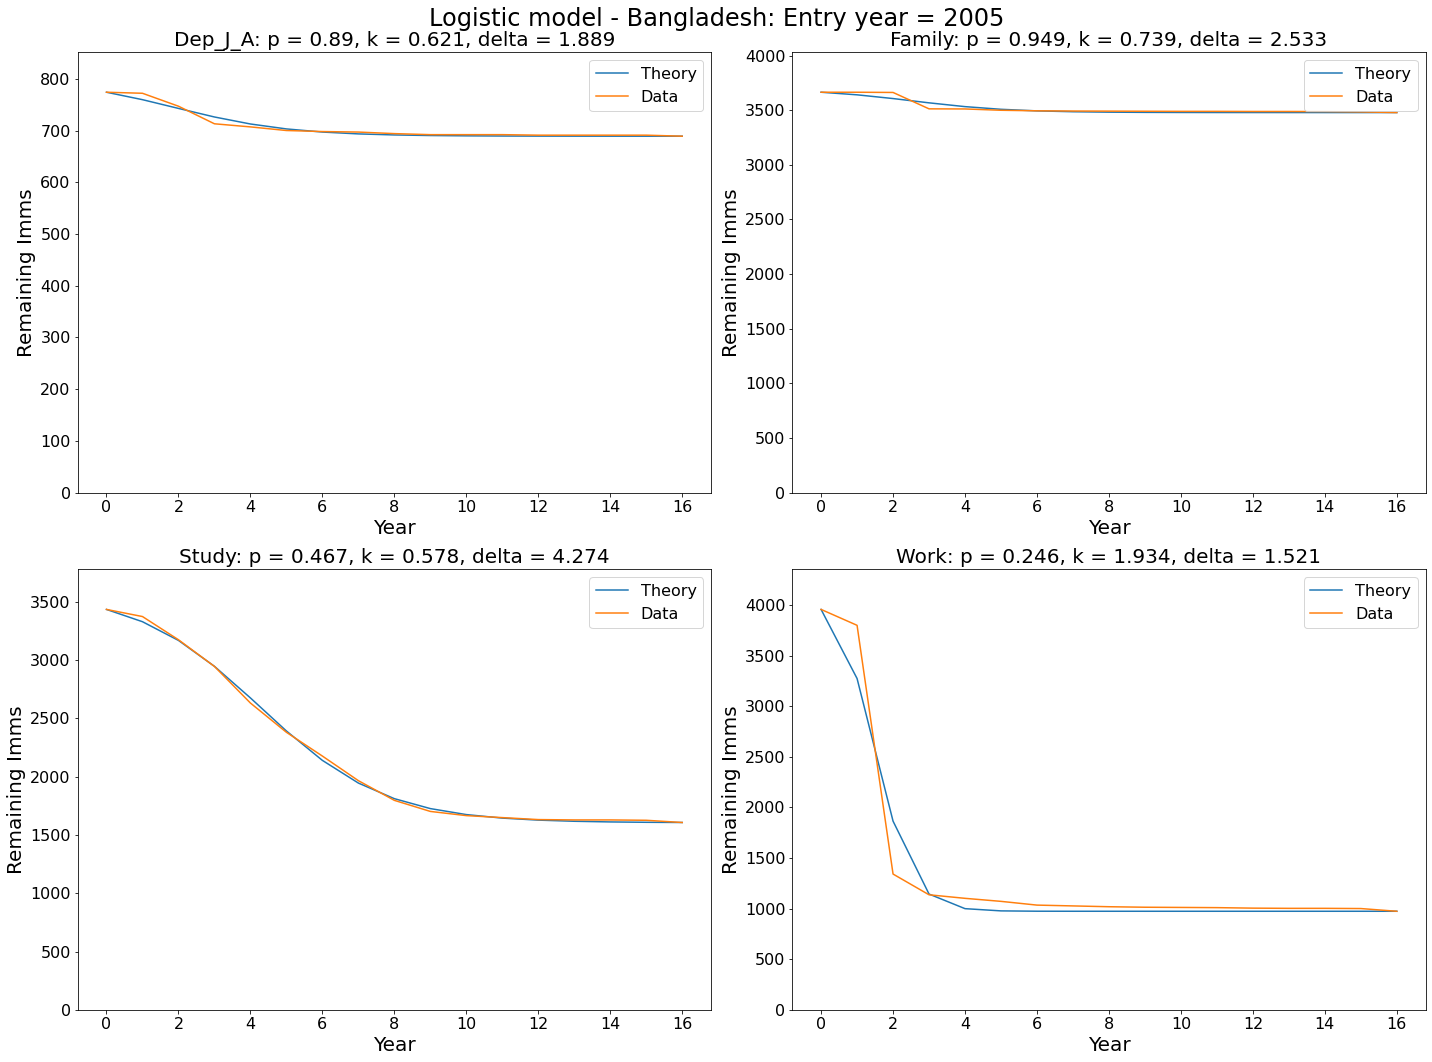

In [7]:
# Fit and draw results from the logistic model. 
# import matplotlib.pyplot as plt

country = 'Bangladesh'
entryYear = 2005

fig, ax = plt.subplots(ncols=2, nrows=2) 

for i in range(len(visaTypes)):
    i_row = i // 2
    i_col = i % 2
    currentVisa = visaTypes[i]
    plot_data, MLE_params, d_dict = getLogisticFit(country, currentVisa, entryYear)
    currentAx = ax[i_row, i_col]
    plot_data.plot.line(x = 'Year', y = ['Theory','Data'], ax=currentAx) 
    currentAx.set_ylim(0, max(plot_data['Data'])*1.1)
    plot_title = visaTypes[i] + ': p = ' + str(np.around(MLE_params[0],3)) + ', k = ' + str(np.around(MLE_params[1],3))  + ', delta = ' + str(np.around(MLE_params[2],3))
    currentAx.set_title(plot_title,fontsize = 20)
    currentAx.set_ylabel('Remaining Imms', fontsize = 20)
    currentAx.set_xlabel(xlabel='Year',fontsize = 20)
    currentAx.tick_params(axis='both', which='major', labelsize=16)
    currentAx.legend(fontsize=16)


fig.set_size_inches(20, 15)
fig.suptitle(f'Logistic model - {country}: Entry year = {entryYear}', fontsize=24)
fig.tight_layout()
plt.show()


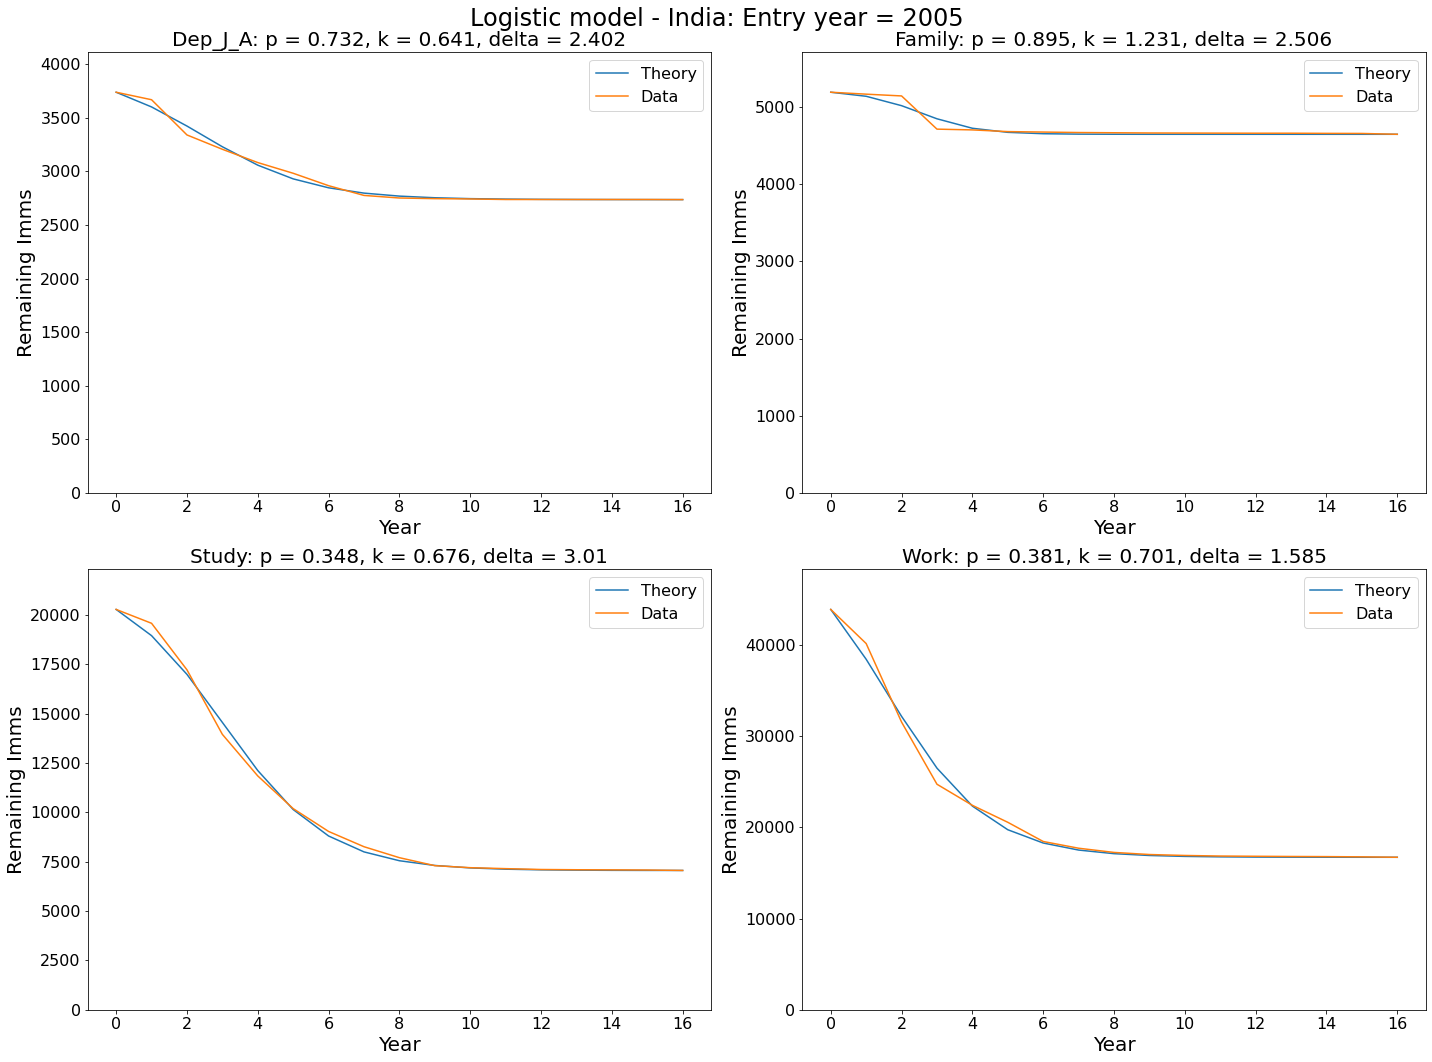

In [8]:
# Fit and draw results from the logistic model. 
# import matplotlib.pyplot as plt

country = 'India'
entryYear = 2005

fig, ax = plt.subplots(ncols=2, nrows=2) 

for i in range(len(visaTypes)):
    i_row = i // 2
    i_col = i % 2
    currentVisa = visaTypes[i]
    plot_data, MLE_params, d_dict = getLogisticFit(country, currentVisa, entryYear)
    currentAx = ax[i_row, i_col]
    plot_data.plot.line(x='Year', y=['Theory', 'Data'], ax=currentAx)
    currentAx.set_ylim(0, max(plot_data['Data'])*1.1)
    plot_title = visaTypes[i] + ': p = ' + str(np.around(MLE_params[0],3)) + ', k = ' + str(np.around(MLE_params[1],3))  + ', delta = ' + str(np.around(MLE_params[2],3))
    currentAx.set_title(plot_title,fontsize = 20)
    currentAx.set_ylabel('Remaining Imms', fontsize = 20)
    currentAx.set_xlabel(xlabel='Year',fontsize = 20)
    currentAx.tick_params(axis='both', which='major', labelsize=16)
    currentAx.legend(fontsize=16)


fig.set_size_inches(20, 15)
fig.suptitle(f'Logistic model - {country}: Entry year = {entryYear}', fontsize=24)
fig.tight_layout()
plt.show()

## Results: across entry years
The fig below shows that the fit looks reasonable up to entry year 2017 (4 independent bits of data). Beyond this, the fit fails. I assume this is because 3 bits of data can define the MLE but says nothing about the shape of the likelihood function at the same time. Hence the optimizing algorithm used to find the MLE can't function.  

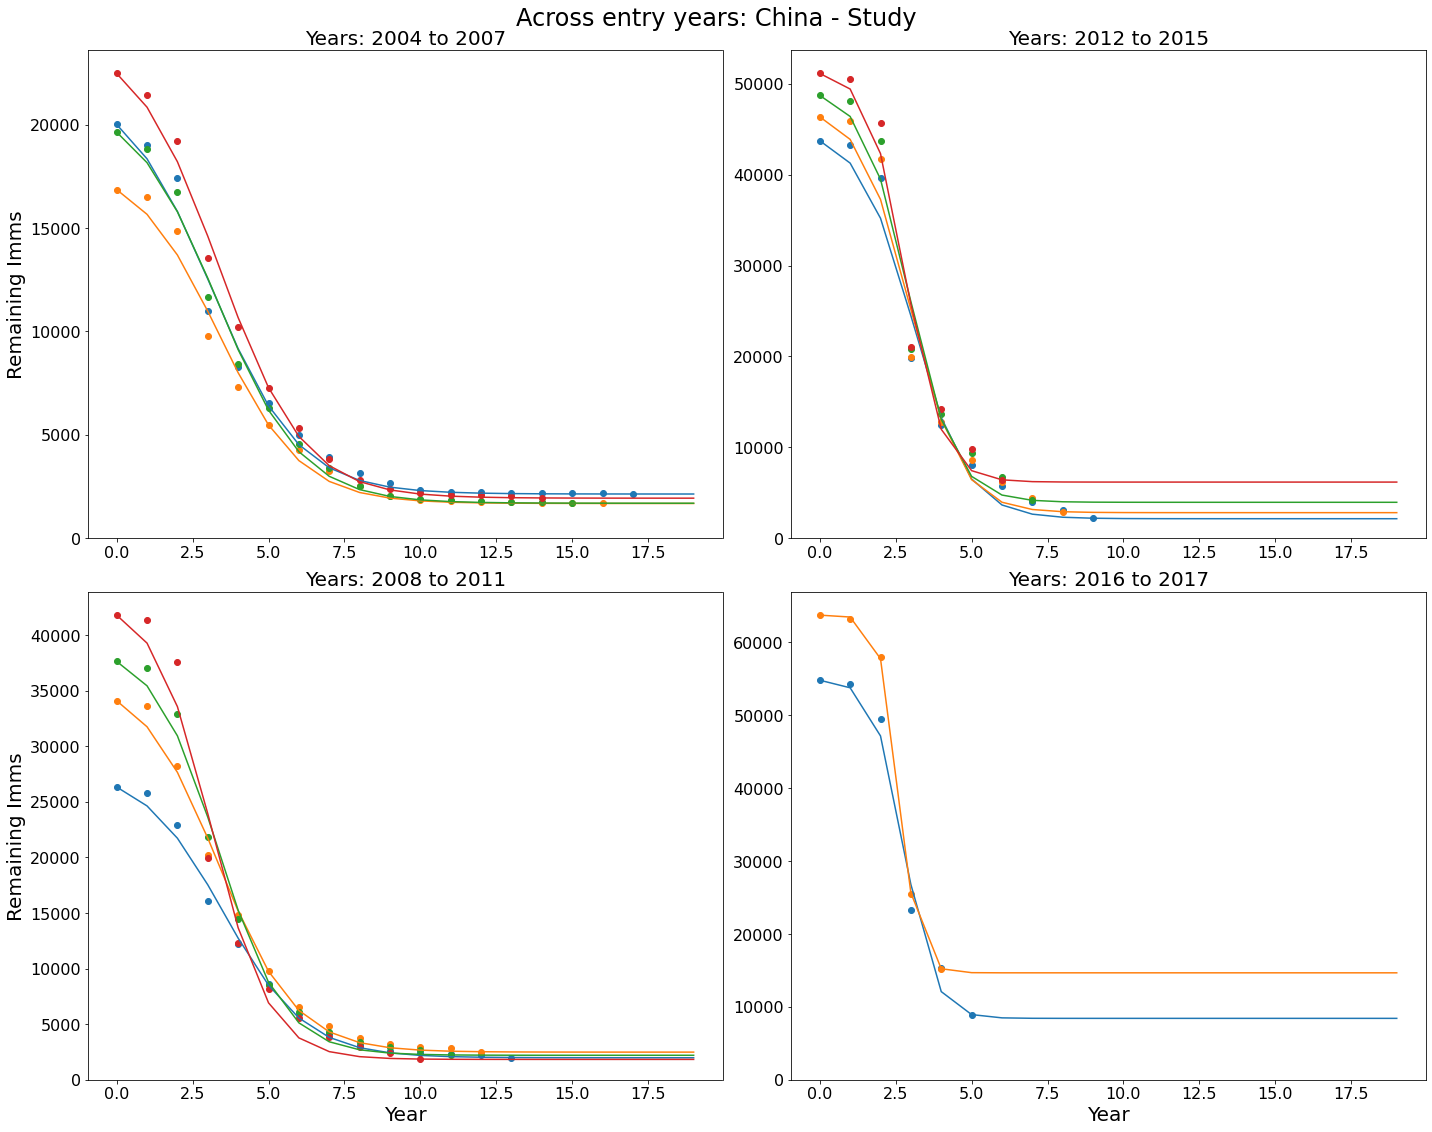

In [9]:
country = 'China'
visa = 'Study'
timeSpan = np.array(range(20))

fig, ax = plt.subplots(ncols=2, nrows=2) 

startYear = 2004
endYear = 2008
maxY = 0
for i in range(startYear, endYear):
    plot_data, MLE_values, d_dict = getLogisticFit(country,visa, i) 
    # create extrapolated soln...
    p = MLE_values[0]
    k = MLE_values[1]
    delta = MLE_values[2]
    s_curve = [0.5*(1-np.tanh(k*(i-delta)/2)) for i in timeSpan]
    theory = (p + (1-p)*np.array(s_curve)/s_curve[0])*plot_data['Data'].values[0]
    ax[0, 0].plot(timeSpan, theory)
    ax[0, 0].scatter(plot_data['Year'], plot_data['Data'])
    maxY = max(maxY, max(plot_data['Data']))

title = f'Years: {startYear} to {endYear-1}'
ax[0, 0].set_title(title, fontsize=20)
ax[0, 0].tick_params(axis='both', which='major', labelsize=16)
ax[0, 0].set_ylim(0, maxY*1.05)

startYear = 2008
endYear = 2012
maxY = 0
for i in range(startYear, endYear):
    plot_data, MLE_values, d_dict = getLogisticFit(country,visa, i) 
    # create extrapolated soln... 
    p = MLE_values[0]
    k = MLE_values[1]
    delta = MLE_values[2]
    s_curve = [0.5*(1-np.tanh(k*(i-delta)/2)) for i in timeSpan]
    theory = (p + (1-p)*np.array(s_curve)/s_curve[0])*plot_data['Data'].values[0]
    ax[1, 0].plot(timeSpan, theory)
    ax[1, 0].scatter(plot_data['Year'], plot_data['Data'])
    maxY = max(maxY, max(plot_data['Data']))

title = f'Years: {startYear} to {endYear-1}'
ax[1, 0].set_title(title, fontsize=20)
ax[1, 0].tick_params(axis='both', which='major', labelsize=16)
ax[1, 0].set_ylim(0, maxY*1.05)


startYear = 2012
endYear = 2016
maxY = 0
for i in range(startYear, endYear):
    plot_data, MLE_values, d_dict = getLogisticFit(country, visa, i) 
    # create extrapolated soln...
    p = MLE_values[0]
    k = MLE_values[1]
    delta = MLE_values[2]
    s_curve = [0.5*(1-np.tanh(k*(i-delta)/2)) for i in timeSpan]
    theory = (p + (1-p)*np.array(s_curve)/s_curve[0])*plot_data['Data'].values[0]
    ax[0, 1].plot(timeSpan, theory)
    ax[0, 1].scatter(plot_data['Year'], plot_data['Data'])
    maxY = max(maxY, max(plot_data['Data']))

title = f'Years: {startYear} to {endYear-1}'
ax[0, 1].set_title(title, fontsize=20)
ax[0, 1].tick_params(axis='both', which='major', labelsize=16)
ax[0, 1].set_ylim(0, maxY*1.05)


startYear = 2016
endYear = 2018
maxY = 0
for i in range(startYear, endYear):
    plot_data, MLE_values, d_dict = getLogisticFit(country,visa, i) 
    # create extrapolated soln...
    p = MLE_values[0]
    k = MLE_values[1]
    delta = MLE_values[2]
    s_curve = [0.5*(1-np.tanh(k*(i-delta)/2)) for i in timeSpan]
    theory = (p + (1-p)*np.array(s_curve)/s_curve[0])*plot_data['Data'].values[0]
    ax[1, 1].plot(timeSpan, theory)
    ax[1, 1].scatter(plot_data['Year'], plot_data['Data'])
    maxY = max(maxY, max(plot_data['Data']))

title = f'Years: {startYear} to {endYear-1}'
ax[1, 1].set_title(title, fontsize=20)
ax[1, 1].tick_params(axis='both', which='major', labelsize=16)
ax[1, 1].set_ylim(0, maxY*1.05)

ax[0, 0].set_ylabel('Remaining Imms', fontsize=20)
ax[1, 0].set_ylabel('Remaining Imms', fontsize=20)
ax[1, 0].set_xlabel(xlabel='Year', fontsize=20)
ax[1, 1].set_xlabel(xlabel='Year', fontsize=20)

fig.set_size_inches(20, 16)
fig.suptitle(f'Across entry years: {country} - {visa}', fontsize=24)
fig.tight_layout()
plt.show()

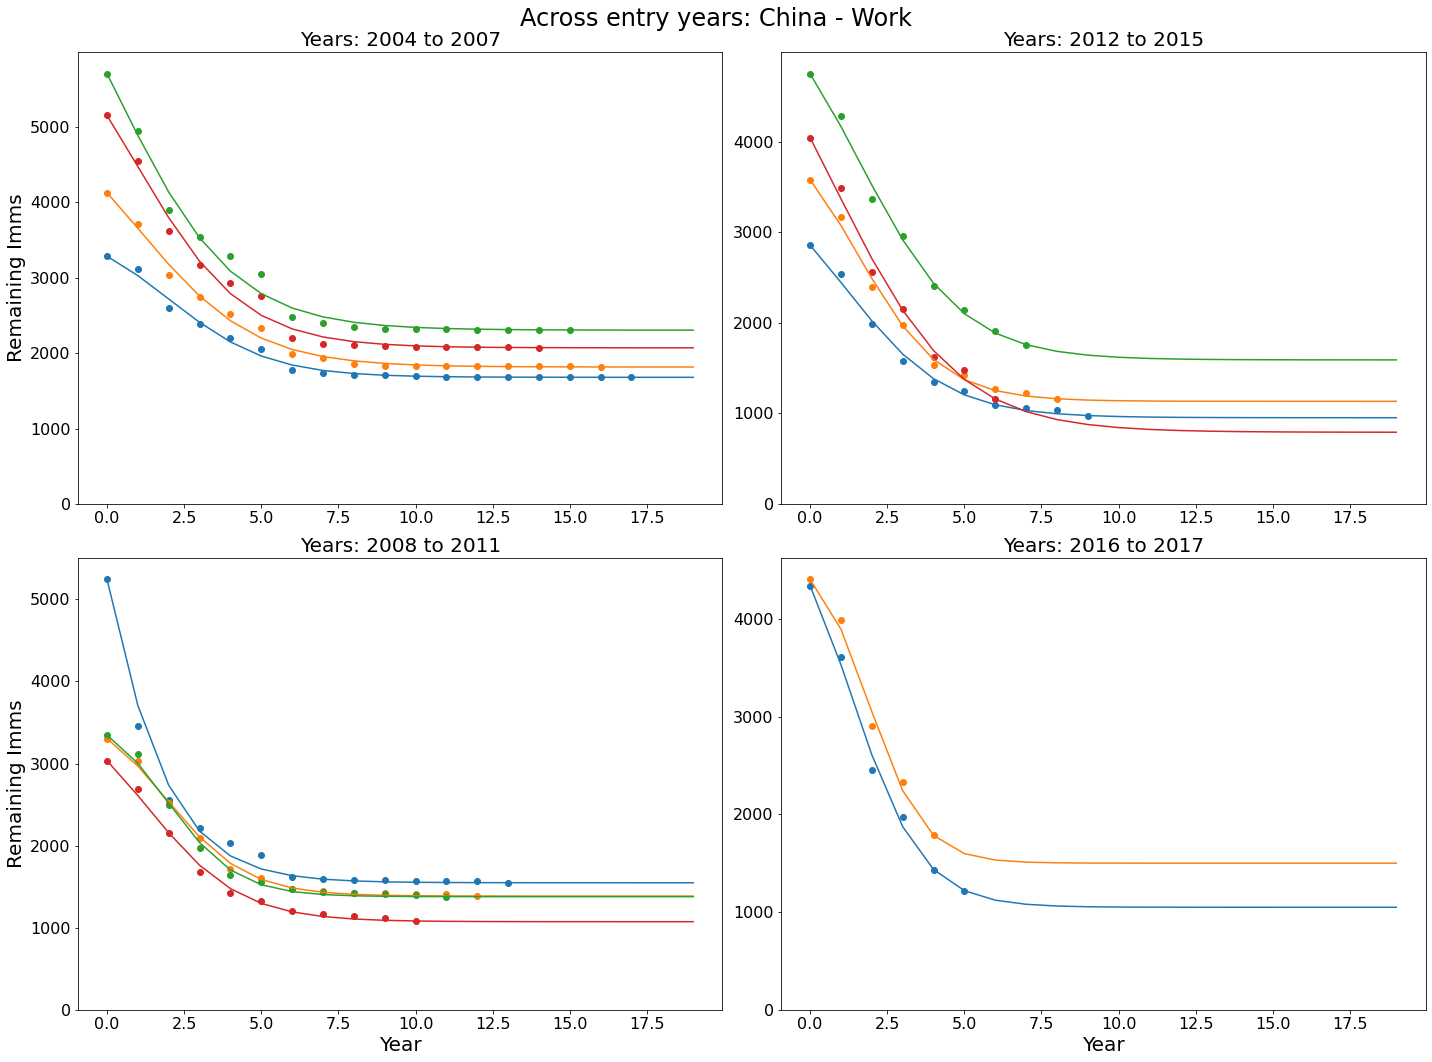

In [10]:
country = 'China'
visa = 'Work'
timeSpan = np.array(range(20))

fig, ax = plt.subplots(ncols=2, nrows=2) 

startYear = 2004
endYear = 2008
maxY = 0
for i in range(startYear, endYear):
    plot_data, MLE_values, d_dict = getLogisticFit(country,visa, i) 
    # create extrapolated soln...
    p = MLE_values[0]
    k = MLE_values[1]
    delta = MLE_values[2]
    s_curve = [0.5*(1-np.tanh(k*(i-delta)/2)) for i in timeSpan]
    theory = (p + (1-p)*np.array(s_curve)/s_curve[0])*plot_data['Data'].values[0]
    ax[0, 0].plot(timeSpan, theory)
    ax[0, 0].scatter(plot_data['Year'], plot_data['Data'])
    maxY = max(maxY, max(plot_data['Data']))

title = f'Years: {startYear} to {endYear-1}'
ax[0, 0].set_title(title, fontsize=20)
ax[0, 0].tick_params(axis='both', which='major', labelsize=16)
ax[0, 0].set_ylim(0, maxY*1.05)

startYear = 2008
endYear = 2012
maxY = 0
for i in range(startYear, endYear):
    plot_data, MLE_values, d_dict = getLogisticFit(country,visa, i) 
    # create extrapolated soln... 
    p = MLE_values[0]
    k = MLE_values[1]
    delta = MLE_values[2]
    s_curve = [0.5*(1-np.tanh(k*(i-delta)/2)) for i in timeSpan]
    theory = (p + (1-p)*np.array(s_curve)/s_curve[0])*plot_data['Data'].values[0]
    ax[1, 0].plot(timeSpan, theory)
    ax[1, 0].scatter(plot_data['Year'], plot_data['Data'])
    maxY = max(maxY, max(plot_data['Data']))

title = f'Years: {startYear} to {endYear-1}'
ax[1, 0].set_title(title, fontsize=20)
ax[1, 0].tick_params(axis='both', which='major', labelsize=16)
ax[1, 0].set_ylim(0, maxY*1.05)


startYear = 2012
endYear = 2016
maxY = 0
for i in range(startYear, endYear):
    plot_data, MLE_values, d_dict = getLogisticFit(country, visa, i) 
    # create extrapolated soln...
    p = MLE_values[0]
    k = MLE_values[1]
    delta = MLE_values[2]
    s_curve = [0.5*(1-np.tanh(k*(i-delta)/2)) for i in timeSpan]
    theory = (p + (1-p)*np.array(s_curve)/s_curve[0])*plot_data['Data'].values[0]
    ax[0, 1].plot(timeSpan, theory)
    ax[0, 1].scatter(plot_data['Year'], plot_data['Data'])
    maxY = max(maxY, max(plot_data['Data']))

title = f'Years: {startYear} to {endYear-1}'
ax[0, 1].set_title(title, fontsize=20)
ax[0, 1].tick_params(axis='both', which='major', labelsize=16)
ax[0, 1].set_ylim(0, maxY*1.05)


startYear = 2016
endYear = 2018
maxY = 0
for i in range(startYear, endYear):
    plot_data, MLE_values, d_dict = getLogisticFit(country,visa, i) 
    # create extrapolated soln...
    p = MLE_values[0]
    k = MLE_values[1]
    delta = MLE_values[2]
    s_curve = [0.5*(1-np.tanh(k*(i-delta)/2)) for i in timeSpan]
    theory = (p + (1-p)*np.array(s_curve)/s_curve[0])*plot_data['Data'].values[0]
    ax[1, 1].plot(timeSpan, theory)
    ax[1, 1].scatter(plot_data['Year'], plot_data['Data'])
    maxY = max(maxY, max(plot_data['Data']))

title = f'Years: {startYear} to {endYear-1}'
ax[1, 1].set_title(title, fontsize=20)
ax[1, 1].tick_params(axis='both', which='major', labelsize=16)
ax[1, 1].set_ylim(0, maxY*1.05)

ax[0, 0].set_ylabel('Remaining Imms', fontsize=20)
ax[1, 0].set_ylabel('Remaining Imms', fontsize=20)
ax[1, 0].set_xlabel(xlabel='Year', fontsize=20)
ax[1, 1].set_xlabel(xlabel='Year', fontsize=20)

fig.set_size_inches(20, 15)
fig.suptitle(f'Across entry years: {country} - {visa}', fontsize=24)
fig.tight_layout()
plt.show()

## Results: dodgy examples
The fits across all countries, visa classes and entry years are calculated and output to a file for reading into the IBM (*Script: ShortImmModelFit.py, cell:Output MLE parameters*). At this point, some apparently dodgy parameters can be seen. Clearly for family visas shown below, the data provides very little information on the long term trend from short runs of data. As a result, the value for the probability of remaining, $p$, is often hugely underestimated (generally to zero). 

We could put in a prior to reflect our understanding that family visa generally imply a desire to stay in the country. The problem is that different datasets have different numbers of individuals in them ($I_0$). As a result, a prior that would bias $p$ away from zero in a small dataset would be overwhelmed by a dataset one or two orders of magnitude larger. A prior would need to be proportional to the number of individuals (the log-prior, I think) and that would then be data-dependent and no longer a prior but part of the model. Experiments with a prior of the form $\log \mbox{Prior} = k p$ weren't very successful at remedying the unrealistic $p$ values. 

Perhaps better to admit that the model is not appropriately informed by the data when the data set is short and to use ones with earlier entry years. Alternatively, model MLEs with very low $p$ values could be thrown out. 

Similar problem for work visa, but from 2016 onwards. 

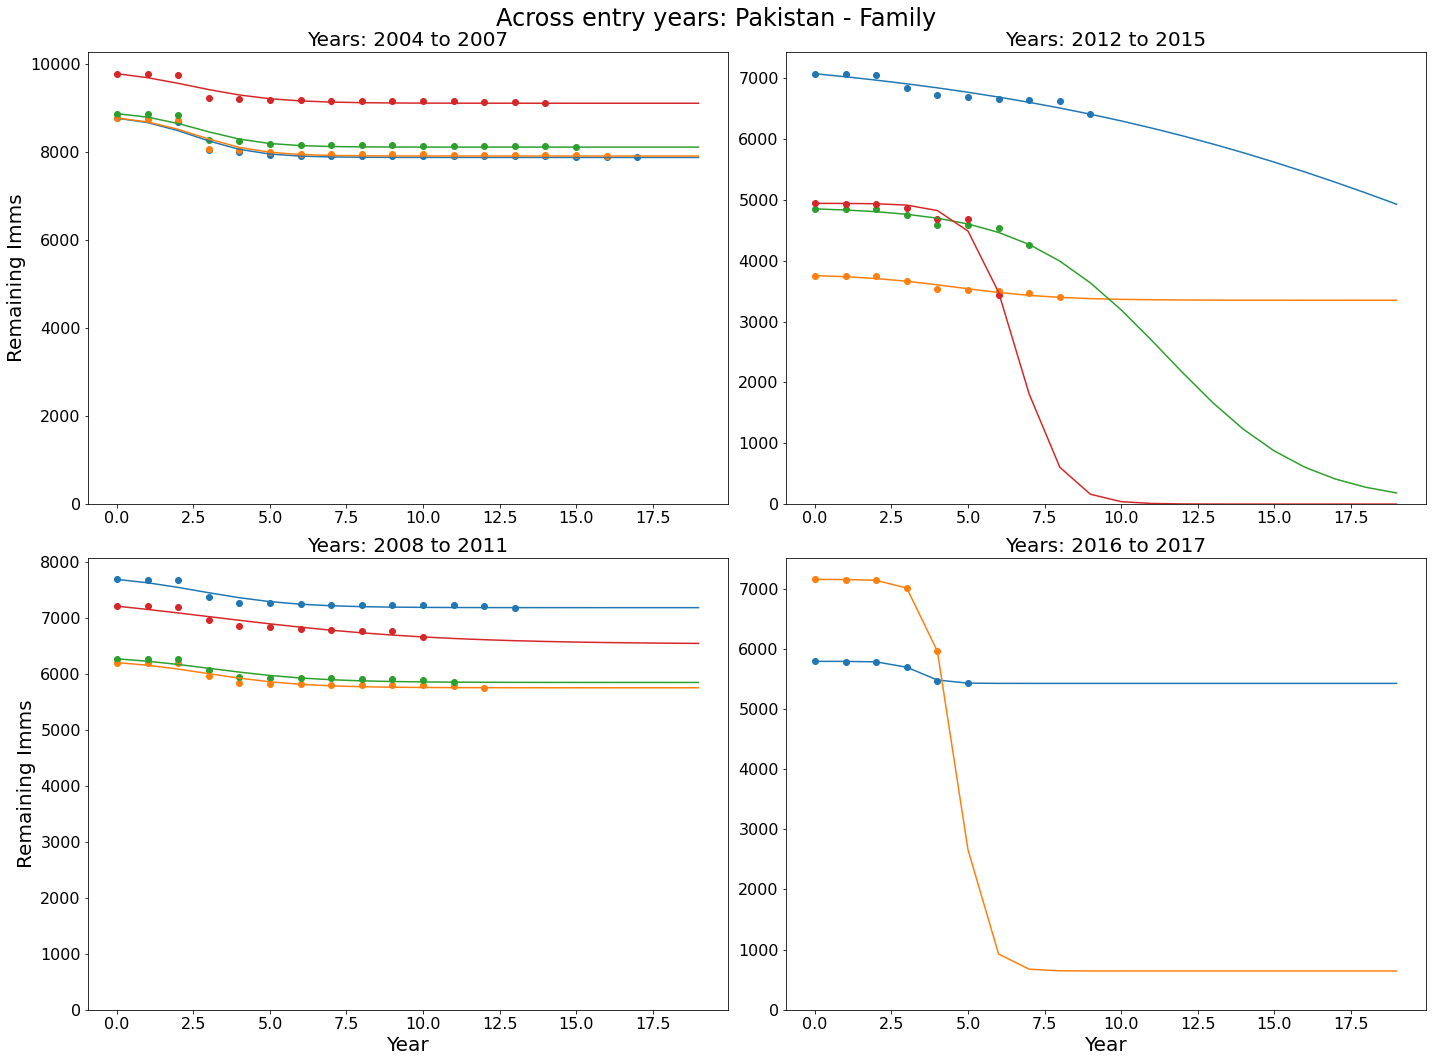

In [11]:
country = 'Pakistan'
visa = 'Family'
timeSpan = np.array(range(20))

fig, ax = plt.subplots(ncols=2, nrows=2) 

startYear = 2004
endYear = 2008
maxY = 0
for i in range(startYear, endYear):
    plot_data, MLE_values, d_dict = getLogisticFit(country,visa, i) 
    # create extrapolated soln...
    p = MLE_values[0]
    k = MLE_values[1]
    delta = MLE_values[2]
    s_curve = [0.5*(1-np.tanh(k*(i-delta)/2)) for i in timeSpan]
    theory = (p + (1-p)*np.array(s_curve)/s_curve[0])*plot_data['Data'].values[0]
    ax[0, 0].plot(timeSpan, theory)
    ax[0, 0].scatter(plot_data['Year'], plot_data['Data'])
    maxY = max(maxY, max(plot_data['Data']))

title = f'Years: {startYear} to {endYear-1}'
ax[0, 0].set_title(title, fontsize=20)
ax[0, 0].tick_params(axis='both', which='major', labelsize=16)
ax[0, 0].set_ylim(0, maxY*1.05)

startYear = 2008
endYear = 2012
maxY = 0
for i in range(startYear, endYear):
    plot_data, MLE_values, d_dict = getLogisticFit(country,visa, i) 
    # create extrapolated soln... 
    p = MLE_values[0]
    k = MLE_values[1]
    delta = MLE_values[2]
    s_curve = [0.5*(1-np.tanh(k*(i-delta)/2)) for i in timeSpan]
    theory = (p + (1-p)*np.array(s_curve)/s_curve[0])*plot_data['Data'].values[0]
    ax[1, 0].plot(timeSpan, theory)
    ax[1, 0].scatter(plot_data['Year'], plot_data['Data'])
    maxY = max(maxY, max(plot_data['Data']))

title = f'Years: {startYear} to {endYear-1}'
ax[1, 0].set_title(title, fontsize=20)
ax[1, 0].tick_params(axis='both', which='major', labelsize=16)
ax[1, 0].set_ylim(0, maxY*1.05)


startYear = 2012
endYear = 2016
maxY = 0
for i in range(startYear, endYear):
    plot_data, MLE_values, d_dict = getLogisticFit(country, visa, i) 
    # create extrapolated soln...
    p = MLE_values[0]
    k = MLE_values[1]
    delta = MLE_values[2]
    s_curve = [0.5*(1-np.tanh(k*(i-delta)/2)) for i in timeSpan]
    theory = (p + (1-p)*np.array(s_curve)/s_curve[0])*plot_data['Data'].values[0]
    ax[0, 1].plot(timeSpan, theory)
    ax[0, 1].scatter(plot_data['Year'], plot_data['Data'])
    maxY = max(maxY, max(plot_data['Data']))

title = f'Years: {startYear} to {endYear-1}'
ax[0, 1].set_title(title, fontsize=20)
ax[0, 1].tick_params(axis='both', which='major', labelsize=16)
ax[0, 1].set_ylim(0, maxY*1.05)


startYear = 2016
endYear = 2018
maxY = 0
for i in range(startYear, endYear):
    plot_data, MLE_values, d_dict = getLogisticFit(country, visa, i)
    # create extrapolated soln...
    p = MLE_values[0]
    k = MLE_values[1]
    delta = MLE_values[2]
    s_curve = [0.5*(1-np.tanh(k*(i-delta)/2)) for i in timeSpan]
    theory = (p + (1-p)*np.array(s_curve)/s_curve[0])*plot_data['Data'].values[0]
    ax[1, 1].plot(timeSpan, theory)
    ax[1, 1].scatter(plot_data['Year'], plot_data['Data'])
    maxY = max(maxY, max(plot_data['Data']))

title = f'Years: {startYear} to {endYear-1}'
ax[1, 1].set_title(title, fontsize=20)
ax[1, 1].tick_params(axis='both', which='major', labelsize=16)
ax[1, 1].set_ylim(0, maxY*1.05)

ax[0, 0].set_ylabel('Remaining Imms', fontsize=20)
ax[1, 0].set_ylabel('Remaining Imms', fontsize=20)
ax[1, 0].set_xlabel(xlabel='Year', fontsize=20)
ax[1, 1].set_xlabel(xlabel='Year', fontsize=20)

fig.set_size_inches(20, 15)
fig.suptitle(f'Across entry years: {country} - {visa}', fontsize=24)
fig.tight_layout()
plt.show()

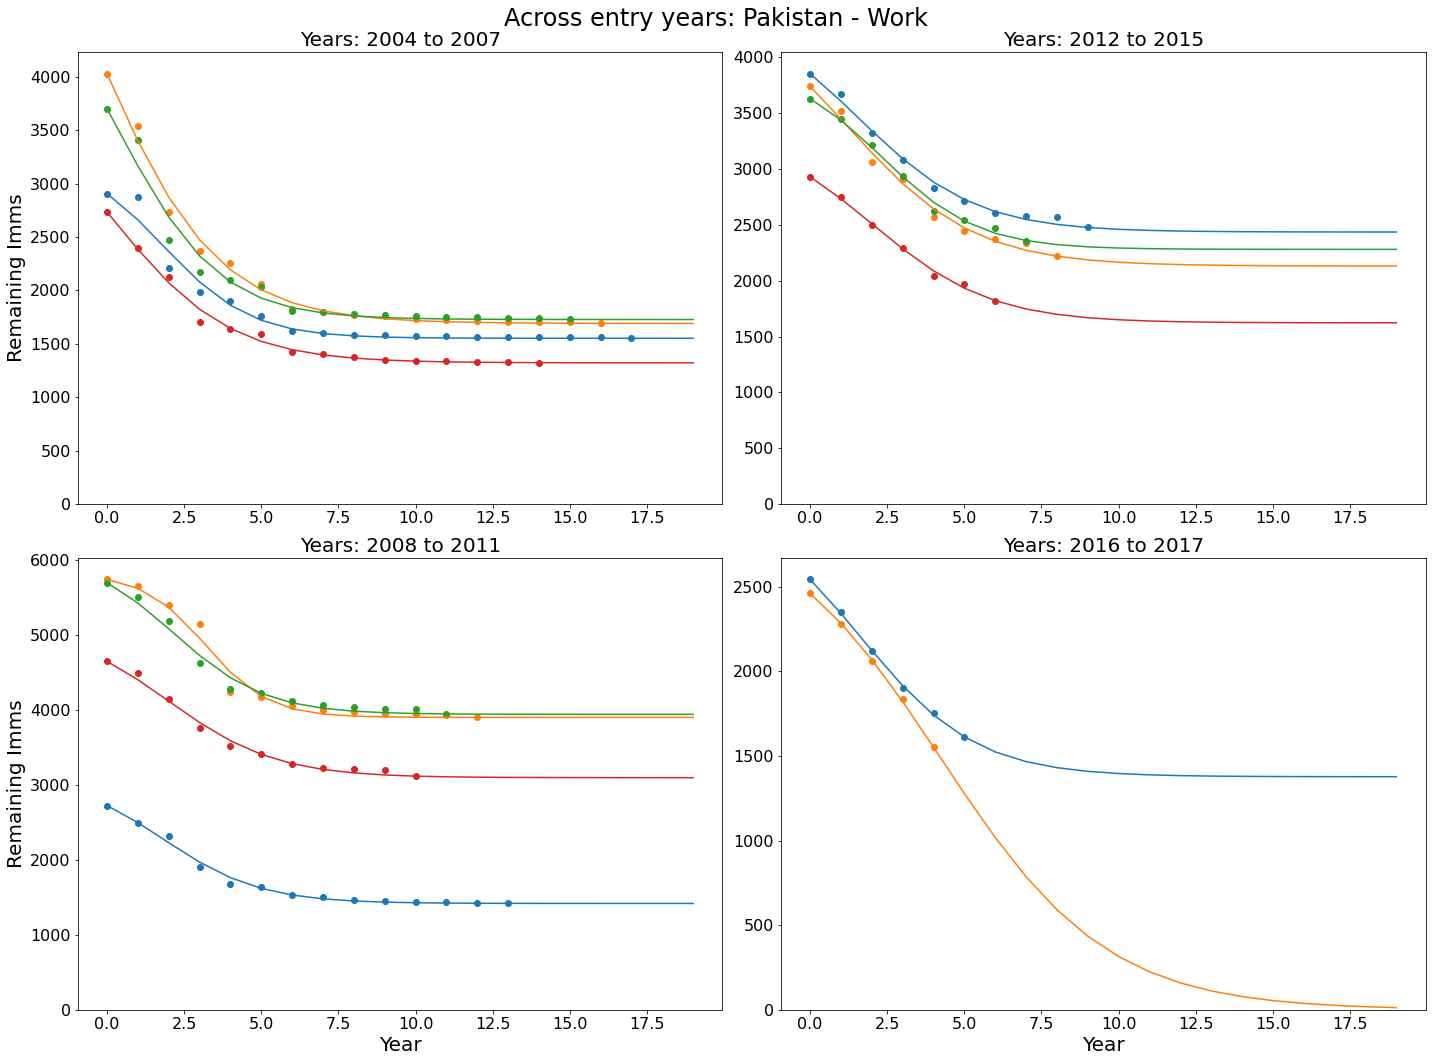

In [12]:
country = 'Pakistan'
visa = 'Work'
timeSpan = np.array(range(20))

fig, ax = plt.subplots(ncols=2, nrows=2) 

startYear = 2004
endYear = 2008
maxY = 0
for i in range(startYear, endYear):
    plot_data, MLE_values, d_dict = getLogisticFit(country,visa, i) 
    # create extrapolated soln...
    p = MLE_values[0]
    k = MLE_values[1]
    delta = MLE_values[2]
    s_curve = [0.5*(1-np.tanh(k*(i-delta)/2)) for i in timeSpan]
    theory = (p + (1-p)*np.array(s_curve)/s_curve[0])*plot_data['Data'].values[0]
    ax[0, 0].plot(timeSpan, theory)
    ax[0, 0].scatter(plot_data['Year'], plot_data['Data'])
    maxY = max(maxY, max(plot_data['Data']))

title = f'Years: {startYear} to {endYear-1}'
ax[0, 0].set_title(title, fontsize=20)
ax[0, 0].tick_params(axis='both', which='major', labelsize=16)
ax[0, 0].set_ylim(0, maxY*1.05)

startYear = 2008
endYear = 2012
maxY = 0
for i in range(startYear, endYear):
    plot_data, MLE_values, d_dict = getLogisticFit(country,visa, i) 
    # create extrapolated soln... 
    p = MLE_values[0]
    k = MLE_values[1]
    delta = MLE_values[2]
    s_curve = [0.5*(1-np.tanh(k*(i-delta)/2)) for i in timeSpan]
    theory = (p + (1-p)*np.array(s_curve)/s_curve[0])*plot_data['Data'].values[0]
    ax[1, 0].plot(timeSpan, theory)
    ax[1, 0].scatter(plot_data['Year'], plot_data['Data'])
    maxY = max(maxY, max(plot_data['Data']))

title = f'Years: {startYear} to {endYear-1}'
ax[1, 0].set_title(title, fontsize=20)
ax[1, 0].tick_params(axis='both', which='major', labelsize=16)
ax[1, 0].set_ylim(0, maxY*1.05)


startYear = 2012
endYear = 2016
maxY = 0
for i in range(startYear, endYear):
    plot_data, MLE_values, d_dict = getLogisticFit(country, visa, i) 
    # create extrapolated soln...
    p = MLE_values[0]
    k = MLE_values[1]
    delta = MLE_values[2]
    s_curve = [0.5*(1-np.tanh(k*(i-delta)/2)) for i in timeSpan]
    theory = (p + (1-p)*np.array(s_curve)/s_curve[0])*plot_data['Data'].values[0]
    ax[0, 1].plot(timeSpan, theory)
    ax[0, 1].scatter(plot_data['Year'], plot_data['Data'])
    maxY = max(maxY, max(plot_data['Data']))

title = f'Years: {startYear} to {endYear-1}'
ax[0, 1].set_title(title, fontsize=20)
ax[0, 1].tick_params(axis='both', which='major', labelsize=16)
ax[0, 1].set_ylim(0, maxY*1.05)


startYear = 2016
endYear = 2018
maxY = 0
for i in range(startYear, endYear):
    plot_data, MLE_values, d_dict = getLogisticFit(country,visa, i) 
    # create extrapolated soln...
    p = MLE_values[0]
    k = MLE_values[1]
    delta = MLE_values[2]
    s_curve = [0.5*(1-np.tanh(k*(i-delta)/2)) for i in timeSpan]
    theory = (p + (1-p)*np.array(s_curve)/s_curve[0])*plot_data['Data'].values[0]
    ax[1, 1].plot(timeSpan, theory)
    ax[1, 1].scatter(plot_data['Year'], plot_data['Data'])
    maxY = max(maxY, max(plot_data['Data']))

title = f'Years: {startYear} to {endYear-1}'
ax[1, 1].set_title(title, fontsize=20)
ax[1, 1].tick_params(axis='both', which='major', labelsize=16)
ax[1, 1].set_ylim(0, maxY*1.05)

ax[0, 0].set_ylabel('Remaining Imms', fontsize=20)
ax[1, 0].set_ylabel('Remaining Imms', fontsize=20)
ax[1, 0].set_xlabel(xlabel='Year', fontsize=20)
ax[1, 1].set_xlabel(xlabel='Year', fontsize=20)

fig.set_size_inches(20, 15)
fig.suptitle(f'Across entry years: {country} - {visa}', fontsize=24)
fig.tight_layout()
plt.show()

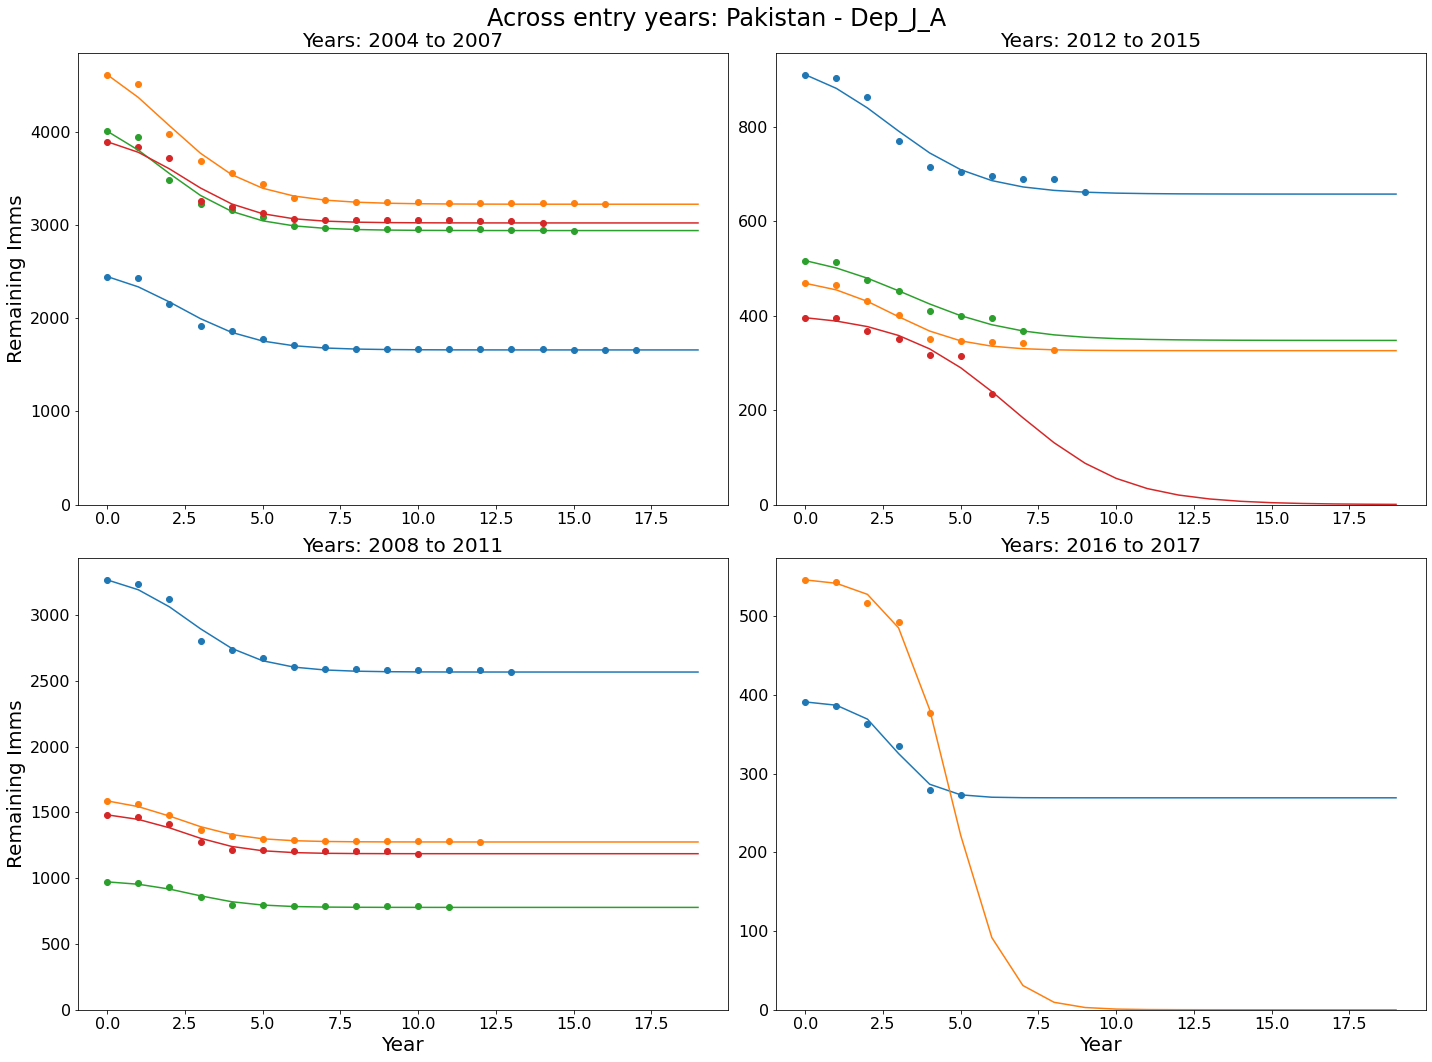

In [13]:
country = 'Pakistan'
visa = 'Dep_J_A'
timeSpan = np.array(range(20))

fig, ax = plt.subplots(ncols=2, nrows=2) 

startYear = 2004
endYear = 2008
maxY = 0
for i in range(startYear, endYear):
    plot_data, MLE_values, d_dict = getLogisticFit(country,visa, i) 
    # create extrapolated soln...
    p = MLE_values[0]
    k = MLE_values[1]
    delta = MLE_values[2]
    s_curve = [0.5*(1-np.tanh(k*(i-delta)/2)) for i in timeSpan]
    theory = (p + (1-p)*np.array(s_curve)/s_curve[0])*plot_data['Data'].values[0]
    ax[0, 0].plot(timeSpan, theory)
    ax[0, 0].scatter(plot_data['Year'], plot_data['Data'])
    maxY = max(maxY, max(plot_data['Data']))

title = f'Years: {startYear} to {endYear-1}'
ax[0, 0].set_title(title, fontsize=20)
ax[0, 0].tick_params(axis='both', which='major', labelsize=16)
ax[0, 0].set_ylim(0, maxY*1.05)

startYear = 2008
endYear = 2012
maxY = 0
for i in range(startYear, endYear):
    plot_data, MLE_values, d_dict = getLogisticFit(country,visa, i) 
    # create extrapolated soln... 
    p = MLE_values[0]
    k = MLE_values[1]
    delta = MLE_values[2]
    s_curve = [0.5*(1-np.tanh(k*(i-delta)/2)) for i in timeSpan]
    theory = (p + (1-p)*np.array(s_curve)/s_curve[0])*plot_data['Data'].values[0]
    ax[1, 0].plot(timeSpan, theory)
    ax[1, 0].scatter(plot_data['Year'], plot_data['Data'])
    maxY = max(maxY, max(plot_data['Data']))

title = f'Years: {startYear} to {endYear-1}'
ax[1, 0].set_title(title, fontsize=20)
ax[1, 0].tick_params(axis='both', which='major', labelsize=16)
ax[1, 0].set_ylim(0, maxY*1.05)


startYear = 2012
endYear = 2016
maxY = 0
for i in range(startYear, endYear):
    plot_data, MLE_values, d_dict = getLogisticFit(country, visa, i) 
    # create extrapolated soln...
    p = MLE_values[0]
    k = MLE_values[1]
    delta = MLE_values[2]
    s_curve = [0.5*(1-np.tanh(k*(i-delta)/2)) for i in timeSpan]
    theory = (p + (1-p)*np.array(s_curve)/s_curve[0])*plot_data['Data'].values[0]
    ax[0, 1].plot(timeSpan, theory)
    ax[0, 1].scatter(plot_data['Year'], plot_data['Data'])
    maxY = max(maxY, max(plot_data['Data']))

title = f'Years: {startYear} to {endYear-1}'
ax[0, 1].set_title(title, fontsize=20)
ax[0, 1].tick_params(axis='both', which='major', labelsize=16)
ax[0, 1].set_ylim(0, maxY*1.05)


startYear = 2016
endYear = 2018
maxY = 0
for i in range(startYear, endYear):
    plot_data, MLE_values, d_dict = getLogisticFit(country,visa, i) 
    # create extrapolated soln...
    p = MLE_values[0]
    k = MLE_values[1]
    delta = MLE_values[2]
    s_curve = [0.5*(1-np.tanh(k*(i-delta)/2)) for i in timeSpan]
    theory = (p + (1-p)*np.array(s_curve)/s_curve[0])*plot_data['Data'].values[0]
    ax[1, 1].plot(timeSpan, theory)
    ax[1, 1].scatter(plot_data['Year'], plot_data['Data'])
    maxY = max(maxY, max(plot_data['Data']))

title = f'Years: {startYear} to {endYear-1}'
ax[1, 1].set_title(title, fontsize=20)
ax[1, 1].tick_params(axis='both', which='major', labelsize=16)
ax[1, 1].set_ylim(0, maxY*1.05)

ax[0, 0].set_ylabel('Remaining Imms', fontsize=20)
ax[1, 0].set_ylabel('Remaining Imms', fontsize=20)
ax[1, 0].set_xlabel(xlabel='Year', fontsize=20)
ax[1, 1].set_xlabel(xlabel='Year', fontsize=20)

fig.set_size_inches(20, 15)
fig.suptitle(f'Across entry years: {country} - {visa}', fontsize=24)
fig.tight_layout()
plt.show()

## Parameter uncertainty
As the previous plots show, the MLE parameters can give apparently good fits to the data but fail to extrapolate forward in time in a credible way. We will only use models with a credible extrapolation, which means rejecting those that have a near-zero MLE for $p$. For the models that remain, what are the uncertainties associated with the parameters? In the graphs below, we show the half 95% credible intervals against the MLE values of the parameters. The half 95% CI gives an approximate 'plus or minus' for the MLE. 

For $p$, the uncertainty is generally below 10% of the MLE. THe few outliers come from models with only just sufficient data to give a realistic extrapolation. For $k$ and $\delta$, the uncertainties are generally larger in comparison to the MLE, although $\delta$ can be plus or minus and so the ratio of uncertainty and MLE is not particularly meaningful. For $k$ and $\delta$, there are often not many data points charting the change from high to low survival, and sometimes the data doesn't full span the change, so it's not surprising that these parameters are sometimes not precisely defined. 

The bottom right figure shows the distribution of times for 99.5% of emigrating individuals to emigrate, based on the MLE parameter values. Except for an outlier at about 38 years, all fall within 25 years of entry.  

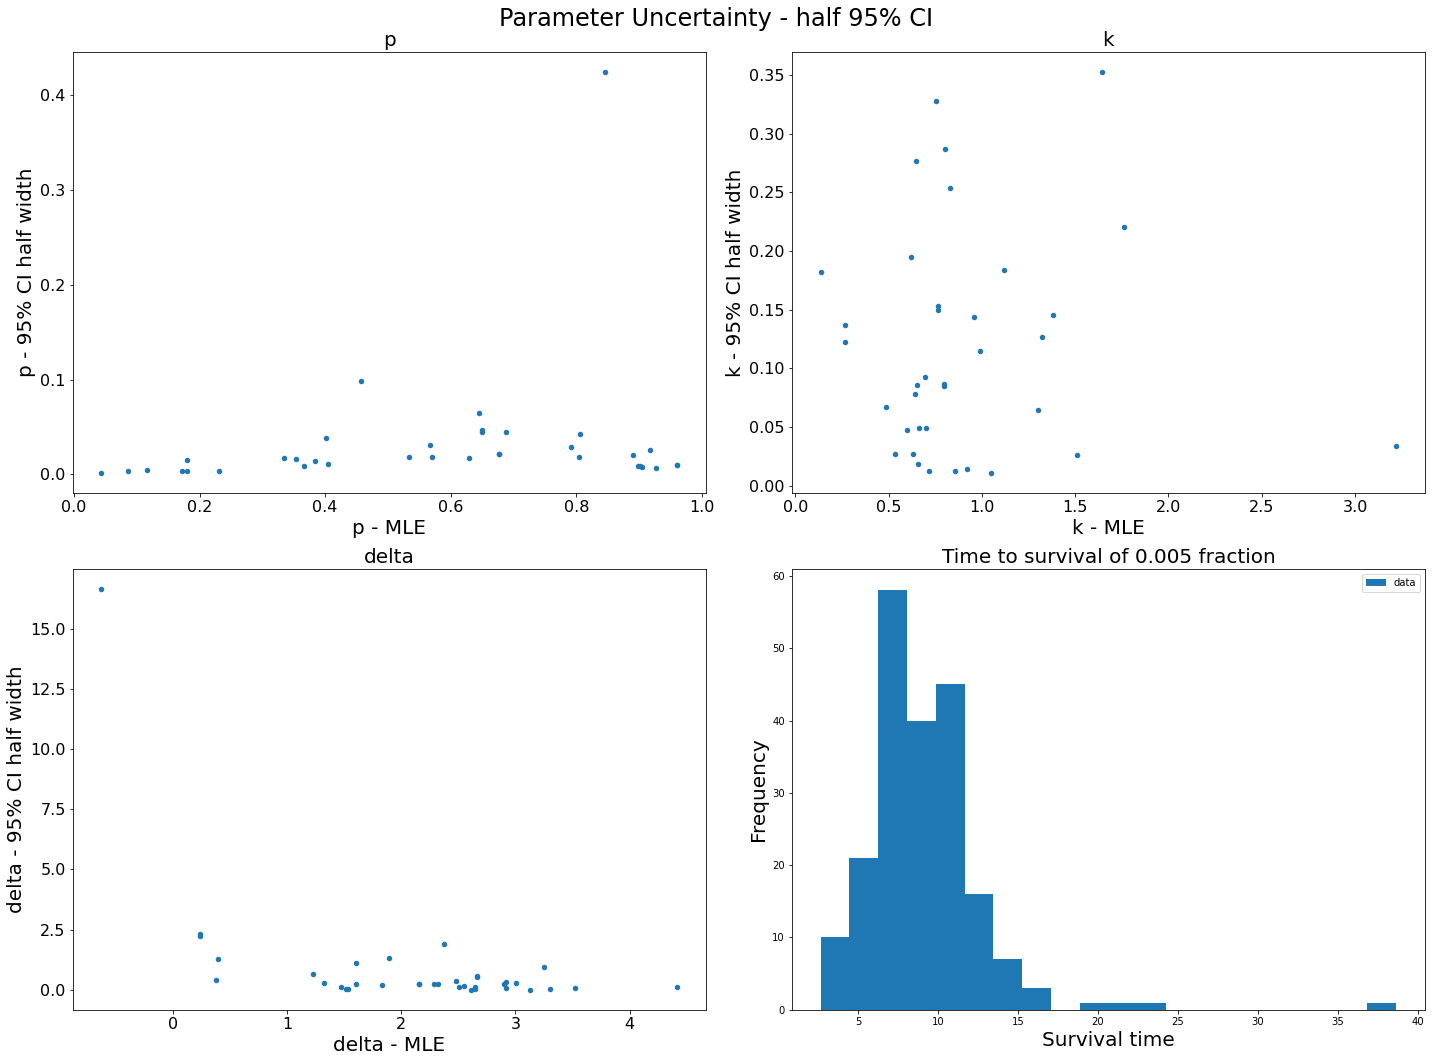

In [14]:
# Read in the valid parameters file created in the previous cell. 
np.random.seed(1)
# paramFileName = 'MJ_InfluxSurvival3.txt'  # was ...2.txt
paramFileName = encPath + f'MJ_InfluxSurvival_{Encoding}.txt'

modelParam_data = pd.read_csv(paramFileName, sep='\t')
# we rely on the order, so reorder.
modCols = list(modelParam_data.columns)
modelParam_data.sort_values(by=modCols[:-1], inplace=True)
modelSize = 4   # number of params stored for each model.
lenData = modelParam_data.shape[0]
nModels = lenData//modelSize

# Pick a random assortment of models. 
NPoints = 50
modelIndices = modelSize*np.random.randint(nModels, size=NPoints)

# create storage for the uncertainty info and x-axis info. 
resIndex = 0
uncert_values = np.zeros(shape=(NPoints, 3))
param_values = np.zeros(shape=(NPoints, 3))
I0_values = np.zeros(NPoints)
N_years = np.zeros(NPoints)

# i = 0
for i in range(NPoints):
    currentIndex = modelIndices[i]
    # Is the model Kosher?
    currentMLEs = modelParam_data['Value'].values[currentIndex:currentIndex+3]
    badModel = currentMLEs[0] < 0
    if badModel:
        continue  # if it's a dud model, go to next. 

    currentCountry = modelParam_data['Country'].values[currentIndex]
    currentVisa = modelParam_data['Visa'].values[currentIndex]
    currentEntryYear = modelParam_data['EntryYear'].values[currentIndex]
    d_dict, CI_95 = getParamUncertainty(currentCountry, currentVisa, currentEntryYear, currentMLEs)

    uncertainty = 0.5*np.diff(CI_95, axis=0)
    param_values[resIndex, :] = currentMLEs

    uncert_values[resIndex, :] = uncertainty
    I0_values[resIndex] = d_dict['I0']
    N_years[resIndex] = 2020 - currentEntryYear
    resIndex += 1

# Don't know which of these we want to plot.
temp = np.concatenate((param_values[:resIndex, :], 
                       uncert_values[:resIndex, :]), axis=1)
plot_df2 = pd.DataFrame(temp)
plot_df2.columns = ['p', 'k', 'delta', 'd_p', 'd_k', 'd_delta']
# plot_df2['I0'] = I0_values[:resIndex]
# plot_df2['Ny'] = N_years[:resIndex]
# plot_df2['logI0'] = np.log(I0_values[:resIndex])
# plot_df2['logp'] = np.log(plot_df2['p'].values)
# plot_df2['logk'] = np.log(plot_df2['k'].values)

fig, ax = plt.subplots(ncols=2, nrows=2) 

currentFig = 'p'
currentAx = ax[0, 0]
y_label = currentFig + ' - 95% CI half width'
x_label = currentFig + ' - MLE'
y_values = 'd_' + currentFig
plot_df2.plot.scatter(x=currentFig, y=y_values, ax=currentAx)
# currentAx.set_xscale('log')
# currentAx.set_yscale('log')
currentAx.set_title(currentFig, fontsize=20)
currentAx.tick_params(axis='both', which='major', labelsize=16)
currentAx.set_xlabel(x_label, fontsize=20)
currentAx.set_ylabel(y_label, fontsize=20)

currentFig = 'k'
currentAx = ax[0, 1]
y_label = currentFig + ' - 95% CI half width'
x_label = currentFig + ' - MLE'
y_values = 'd_' + currentFig
plot_df2.plot.scatter(x=currentFig, y=y_values, ax=currentAx)
# currentAx.set_xscale('log')
# currentAx.set_yscale('log')
currentAx.set_title(currentFig, fontsize=20)
currentAx.tick_params(axis='both', which='major', labelsize=16)
currentAx.set_xlabel(x_label, fontsize=20)
currentAx.set_ylabel(y_label, fontsize=20)

currentFig = 'delta'
currentAx = ax[1, 0]
y_label = currentFig + ' - 95% CI half width'
y_values = 'd_' + currentFig
x_label = currentFig + ' - MLE'
plot_df2.plot.scatter(x=currentFig, y=y_values, ax=currentAx)
currentAx.set_title(currentFig, fontsize=20)
currentAx.tick_params(axis='both', which='major', labelsize=16)
currentAx.set_xlabel(x_label, fontsize=20)
currentAx.set_ylabel(y_label, fontsize=20)

# How long to get to 0.5% survival for re-emigrating population?
resIndex = 0
minFracSurvival = 0.005
maxStore = np.zeros(nModels)

for i in range(nModels):
    currentIndex = i*modelSize
    # Is the model Kosher?
    currentMLEs = modelParam_data['Value'].values[currentIndex:currentIndex+3]
    badModel = currentMLEs[0] < 0
    if badModel:
        continue  # if it's a dud model, go to next.

    maxStore[resIndex] = currentMLEs[2] - np.log(minFracSurvival)/currentMLEs[1]

    resIndex += 1


data_dict = {'data': maxStore[:resIndex]}
plot_df = pd.DataFrame(data_dict)


currentAx = ax[1, 1]
plot_df.plot.hist(bins=20, ax=currentAx)
title = f'Time to survival of {minFracSurvival} fraction'
currentAx.set_title(title, fontsize=20)
x_label = 'Survival time'
currentAx.set_xlabel(x_label, fontsize=20)
currentAx.set_ylabel('Frequency', fontsize=20)

fig.set_size_inches(20, 15)
fig.suptitle('Parameter Uncertainty - half 95% CI', fontsize=24)
fig.tight_layout()
plt.show()

## Conclusions
It looks like the logistic survival model is generally adequate to describe the behaviour of the different visa categories and countries. There seems to be only one mode of failure: the failure to pick up on a credible final proportion of individuals that apparently become long-term residents. The fitting algorithm effectively assigns $p = 0$  to these cases. 

I propose to filter out the extremely low $p$ cases. The datafile read in will contain 4 parameters for each combination of country, visa and entry year; $p, k, \delta, I_0$. In cases where the fit has failed, the first 3 parameters will be set to 0 (or-1) while the 4th contains the correct influx value. Within the IBM the code can search nearby entry years for a valid parameterisation where necessary and use that. 

The bottom-right figure above shows that most re-emigrators leave again within 25 years. As a result, we can store entry year in the IBM as entry year relative to current model year, and we only need to store about 25 years of past entry years to capture the great majority of the re-emigration behaviour. The remainers will be subsumed into the general aggregated population. 

Parameter uncertainty is generally low for $p$, but can be high for the other parameters. Is it worth including this uncertainty in the IBM runs? I think not because the uncertainty in other parameters is likely to be much greater and have a greater impact on the results. Also, inclusion of uncertainty would require having multiple large data files with parameter samples from the likelihood/posterior, which is quite a hassle. 

*N.B.* The likelihood function for the logistic model was estremely temperamental and consistently failed to work with any maximising algorithms other than Nelder-Mead. Errors generally concerned divide by zero and log of -ve.  

## 3-visa aggregation + Sub-Saharan Africa - Encoding: **3v6c**
N.B. it's **6c** because in the IBM code, white is also present. In the current dataset, there are two types of family visa; **Family** and **Dep_J_A**. In some countries, one of these (which?) has very low numbers. There's also evidence from the E-DETECT-TB data that the uses of these have changed recently, but that the total of the two may be more stable over time. We've also allowed Sub-Saharan Africa to be included, making 5 countries in all. 

As a result, we're going to aggregate the two family visas into one, **FamilyAgg**. This also saves memory in the IBM. 

In [15]:
# The new encoding.
Encoding = '3v6c'  # was 3v5c

encodingFileName = encPath + f'DefEncoding_{Encoding}.p'
pickle_input = open(encodingFileName, 'rb')
country2Index_dict, sexes, defVisaCats, Visa2Index_dict, visaSet, \
    EDetTB2VisaCats, regionSet = pickle.load(pickle_input)


# Code snippet to aggregate the two family visas into 1. 
oldValues = ['Dep_J_A', 'Family']
newValue = 'FamilyAgg'
NewLaura_data = laura_data.replace(to_replace=oldValues, value=newValue)

grouped = NewLaura_data.groupby(colNames[:-1])
gTotals = grouped['value'].agg(np.sum)

test = [list(i) + [v] for i, v in gTotals.iteritems()]
newData = pd.DataFrame(test)
newData.columns = colNames
laura_data = newData

# Print a summary... 
summary = [[x] + [np.unique(laura_data[x])] for x in colNames]
for x in summary:
    print(x)

# Convert to required format. 
raw_data = laura2MJformat(laura_data) 

['nationality', array(['Bangladesh', 'China', 'India', 'Pakistan', 'Sub_Saharan_Africa'],
      dtype=object)]
['year_issued', array([2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014,
       2015, 2016, 2017, 2018, 2019, 2020], dtype=int64)]
['visa_cat_broad', array(['FamilyAgg', 'Study', 'Work'], dtype=object)]
['year', array([2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014,
       2015, 2016, 2017, 2018, 2019, 2020], dtype=int64)]
['status_year_end', array(['Expired', 'Valid visa'], dtype=object)]
['value', array([    0,     1,     2, ..., 71330, 76854, 87994], dtype=int64)]


The survival curves for **FamilyAgg** are largely the same as for **Family**, probably because the numbers in **Family** are about an order of magnitude greater that **Dep_J_A** in general. 

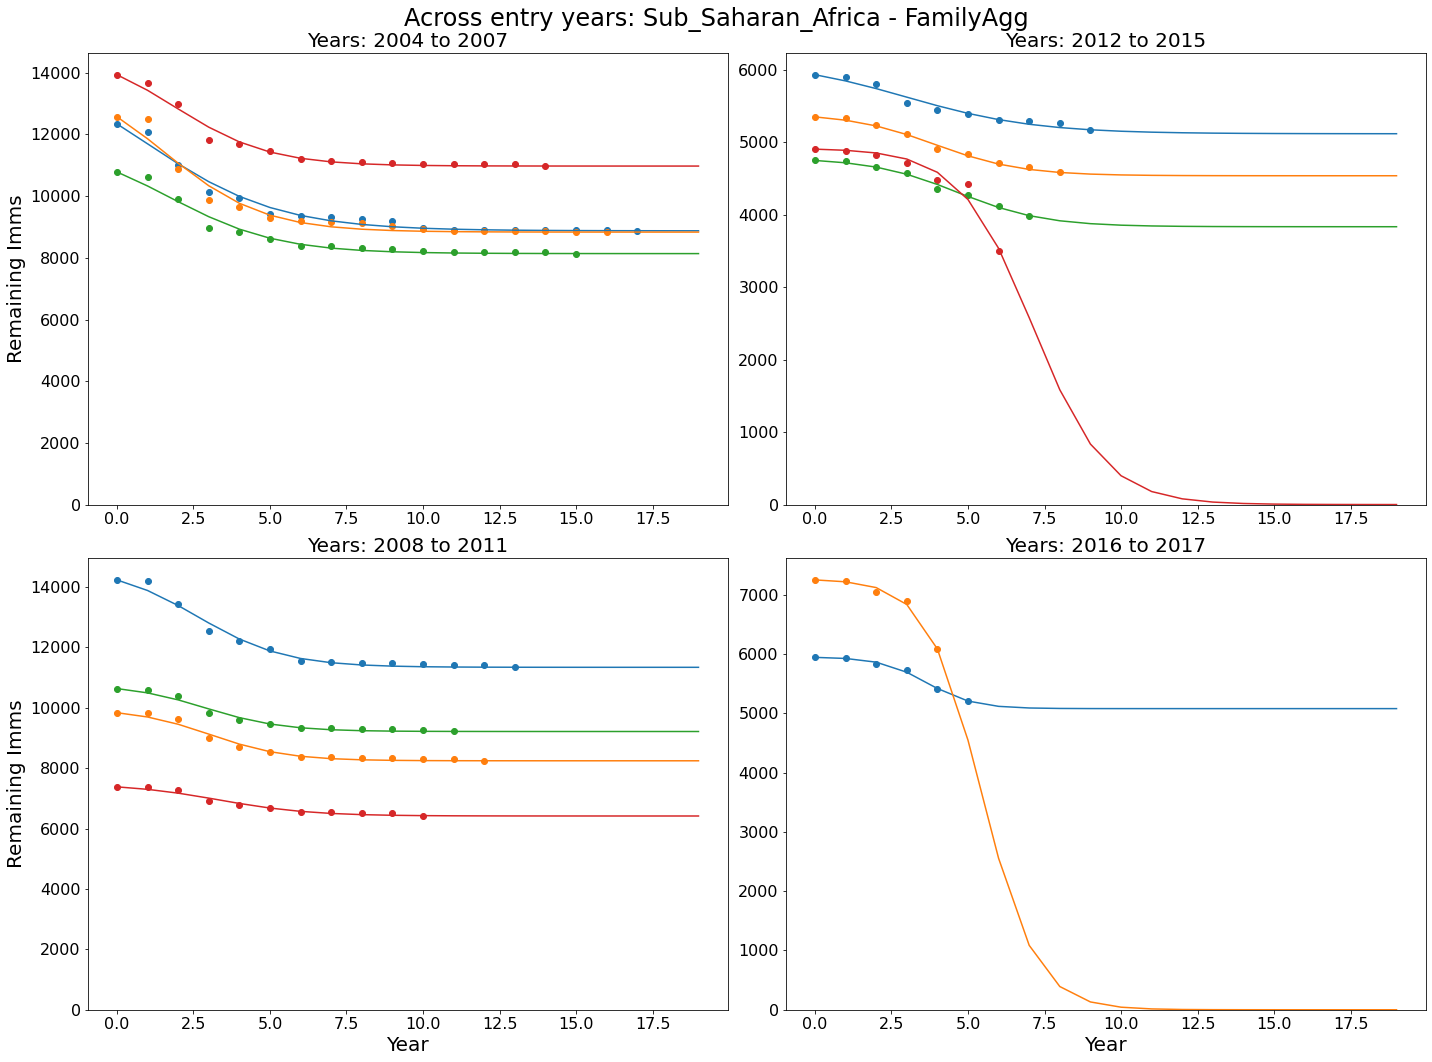

In [16]:
country = 'Sub_Saharan_Africa'
visa = 'FamilyAgg'
timeSpan = np.array(range(20))

fig, ax = plt.subplots(ncols=2, nrows=2) 

startYear = 2004
endYear = 2008
maxY = 0
for i in range(startYear, endYear):
    plot_data, MLE_values, d_dict = getLogisticFit(country,visa, i) 
    # create extrapolated soln...
    p = MLE_values[0]
    k = MLE_values[1]
    delta = MLE_values[2]
    s_curve = [0.5*(1-np.tanh(k*(i-delta)/2)) for i in timeSpan]
    theory = (p + (1-p)*np.array(s_curve)/s_curve[0])*plot_data['Data'].values[0]
    ax[0, 0].plot(timeSpan, theory)
    ax[0, 0].scatter(plot_data['Year'], plot_data['Data'])
    maxY = max(maxY, max(plot_data['Data']))

title = f'Years: {startYear} to {endYear-1}'
ax[0, 0].set_title(title, fontsize=20)
ax[0, 0].tick_params(axis='both', which='major', labelsize=16)
ax[0, 0].set_ylim(0, maxY*1.05)

startYear = 2008
endYear = 2012
maxY = 0
for i in range(startYear, endYear):
    plot_data, MLE_values, d_dict = getLogisticFit(country,visa, i) 
    # create extrapolated soln... 
    p = MLE_values[0]
    k = MLE_values[1]
    delta = MLE_values[2]
    s_curve = [0.5*(1-np.tanh(k*(i-delta)/2)) for i in timeSpan]
    theory = (p + (1-p)*np.array(s_curve)/s_curve[0])*plot_data['Data'].values[0]
    ax[1, 0].plot(timeSpan, theory)
    ax[1, 0].scatter(plot_data['Year'], plot_data['Data'])
    maxY = max(maxY, max(plot_data['Data']))

title = f'Years: {startYear} to {endYear-1}'
ax[1, 0].set_title(title, fontsize=20)
ax[1, 0].tick_params(axis='both', which='major', labelsize=16)
ax[1, 0].set_ylim(0, maxY*1.05)


startYear = 2012
endYear = 2016
maxY = 0
for i in range(startYear, endYear):
    plot_data, MLE_values, d_dict = getLogisticFit(country, visa, i) 
    # create extrapolated soln...
    p = MLE_values[0]
    k = MLE_values[1]
    delta = MLE_values[2]
    s_curve = [0.5*(1-np.tanh(k*(i-delta)/2)) for i in timeSpan]
    theory = (p + (1-p)*np.array(s_curve)/s_curve[0])*plot_data['Data'].values[0]
    ax[0, 1].plot(timeSpan, theory)
    ax[0, 1].scatter(plot_data['Year'], plot_data['Data'])
    maxY = max(maxY, max(plot_data['Data']))

title = f'Years: {startYear} to {endYear-1}'
ax[0, 1].set_title(title, fontsize=20)
ax[0, 1].tick_params(axis='both', which='major', labelsize=16)
ax[0, 1].set_ylim(0, maxY*1.05)


startYear = 2016
endYear = 2018
maxY = 0
for i in range(startYear, endYear):
    plot_data, MLE_values, d_dict = getLogisticFit(country,visa, i) 
    # create extrapolated soln...
    p = MLE_values[0]
    k = MLE_values[1]
    delta = MLE_values[2]
    s_curve = [0.5*(1-np.tanh(k*(i-delta)/2)) for i in timeSpan]
    theory = (p + (1-p)*np.array(s_curve)/s_curve[0])*plot_data['Data'].values[0]
    ax[1, 1].plot(timeSpan, theory)
    ax[1, 1].scatter(plot_data['Year'], plot_data['Data'])
    maxY = max(maxY, max(plot_data['Data']))

title = f'Years: {startYear} to {endYear-1}'
ax[1, 1].set_title(title, fontsize=20)
ax[1, 1].tick_params(axis='both', which='major', labelsize=16)
ax[1, 1].set_ylim(0, maxY*1.05)

ax[0, 0].set_ylabel('Remaining Imms', fontsize=20)
ax[1, 0].set_ylabel('Remaining Imms', fontsize=20)
ax[1, 0].set_xlabel(xlabel='Year', fontsize=20)
ax[1, 1].set_xlabel(xlabel='Year', fontsize=20)

fig.set_size_inches(20, 15)
fig.suptitle(f'Across entry years: {country} - {visa}', fontsize=24)
fig.tight_layout()
plt.show()

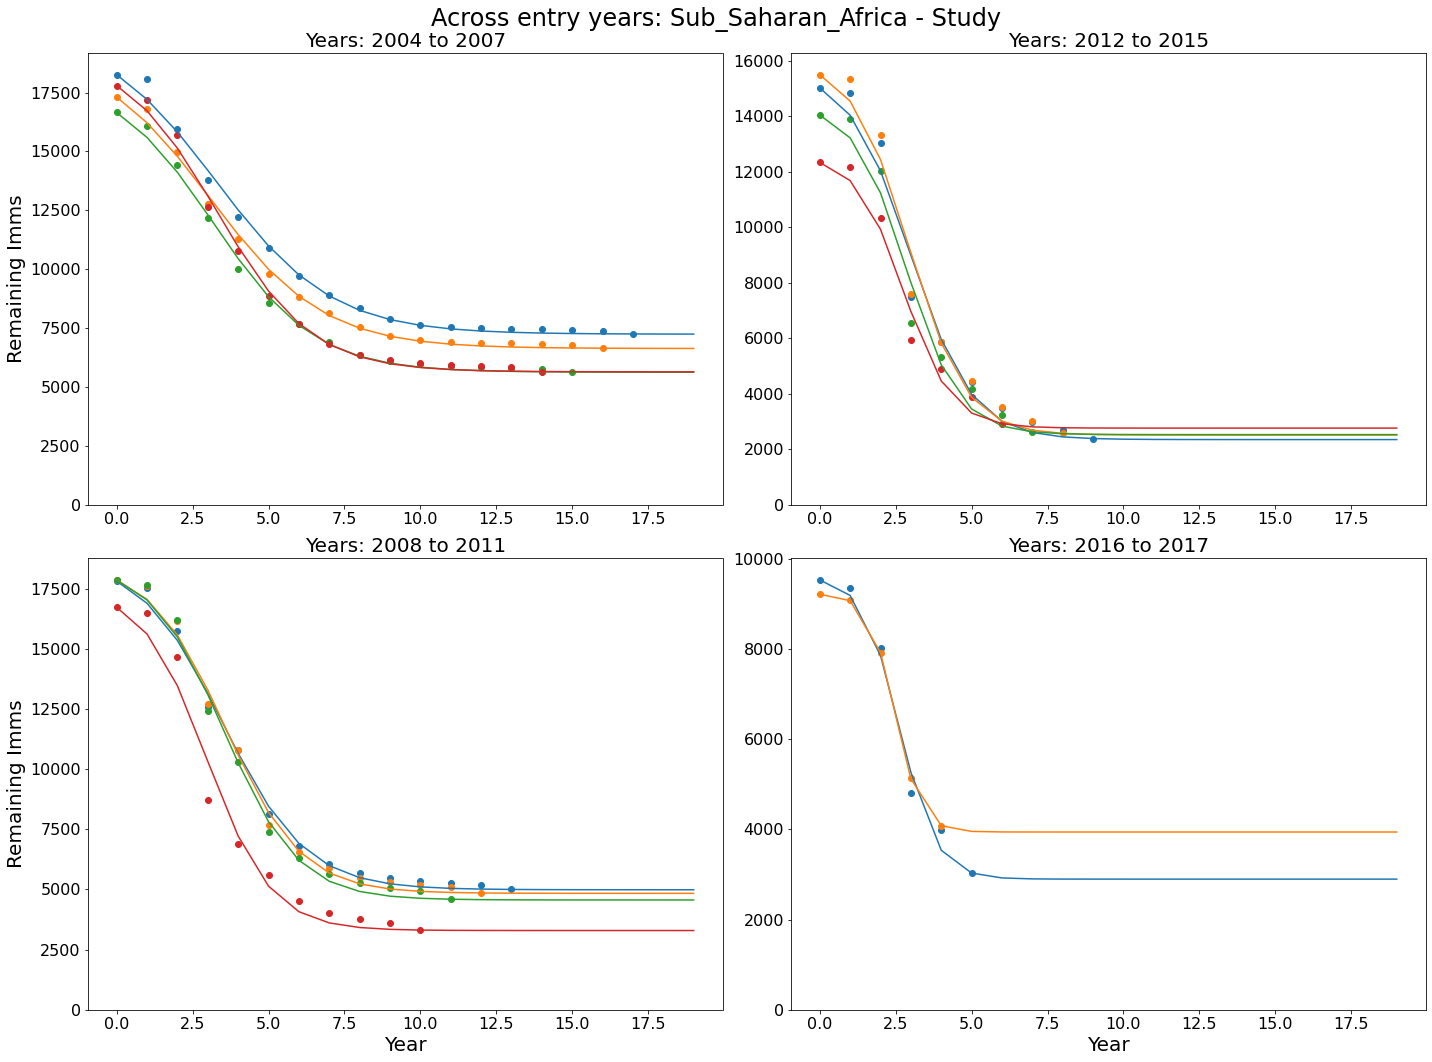

In [17]:
country = 'Sub_Saharan_Africa'
visa = 'Study'
timeSpan = np.array(range(20))

fig, ax = plt.subplots(ncols=2, nrows=2) 

startYear = 2004
endYear = 2008
maxY = 0
for i in range(startYear, endYear):
    plot_data, MLE_values, d_dict = getLogisticFit(country,visa, i) 
    # create extrapolated soln...
    p = MLE_values[0]
    k = MLE_values[1]
    delta = MLE_values[2]
    s_curve = [0.5*(1-np.tanh(k*(i-delta)/2)) for i in timeSpan]
    theory = (p + (1-p)*np.array(s_curve)/s_curve[0])*plot_data['Data'].values[0]
    ax[0, 0].plot(timeSpan, theory)
    ax[0, 0].scatter(plot_data['Year'], plot_data['Data'])
    maxY = max(maxY, max(plot_data['Data']))

title = f'Years: {startYear} to {endYear-1}'
ax[0, 0].set_title(title, fontsize=20)
ax[0, 0].tick_params(axis='both', which='major', labelsize=16)
ax[0, 0].set_ylim(0, maxY*1.05)

startYear = 2008
endYear = 2012
maxY = 0
for i in range(startYear, endYear):
    plot_data, MLE_values, d_dict = getLogisticFit(country,visa, i) 
    # create extrapolated soln... 
    p = MLE_values[0]
    k = MLE_values[1]
    delta = MLE_values[2]
    s_curve = [0.5*(1-np.tanh(k*(i-delta)/2)) for i in timeSpan]
    theory = (p + (1-p)*np.array(s_curve)/s_curve[0])*plot_data['Data'].values[0]
    ax[1, 0].plot(timeSpan, theory)
    ax[1, 0].scatter(plot_data['Year'], plot_data['Data'])
    maxY = max(maxY, max(plot_data['Data']))

title = f'Years: {startYear} to {endYear-1}'
ax[1, 0].set_title(title, fontsize=20)
ax[1, 0].tick_params(axis='both', which='major', labelsize=16)
ax[1, 0].set_ylim(0, maxY*1.05)


startYear = 2012
endYear = 2016
maxY = 0
for i in range(startYear, endYear):
    plot_data, MLE_values, d_dict = getLogisticFit(country, visa, i) 
    # create extrapolated soln...
    p = MLE_values[0]
    k = MLE_values[1]
    delta = MLE_values[2]
    s_curve = [0.5*(1-np.tanh(k*(i-delta)/2)) for i in timeSpan]
    theory = (p + (1-p)*np.array(s_curve)/s_curve[0])*plot_data['Data'].values[0]
    ax[0, 1].plot(timeSpan, theory)
    ax[0, 1].scatter(plot_data['Year'], plot_data['Data'])
    maxY = max(maxY, max(plot_data['Data']))

title = f'Years: {startYear} to {endYear-1}'
ax[0, 1].set_title(title, fontsize=20)
ax[0, 1].tick_params(axis='both', which='major', labelsize=16)
ax[0, 1].set_ylim(0, maxY*1.05)


startYear = 2016
endYear = 2018
maxY = 0
for i in range(startYear, endYear):
    plot_data, MLE_values, d_dict = getLogisticFit(country,visa, i) 
    # create extrapolated soln...
    p = MLE_values[0]
    k = MLE_values[1]
    delta = MLE_values[2]
    s_curve = [0.5*(1-np.tanh(k*(i-delta)/2)) for i in timeSpan]
    theory = (p + (1-p)*np.array(s_curve)/s_curve[0])*plot_data['Data'].values[0]
    ax[1, 1].plot(timeSpan, theory)
    ax[1, 1].scatter(plot_data['Year'], plot_data['Data'])
    maxY = max(maxY, max(plot_data['Data']))

title = f'Years: {startYear} to {endYear-1}'
ax[1, 1].set_title(title, fontsize=20)
ax[1, 1].tick_params(axis='both', which='major', labelsize=16)
ax[1, 1].set_ylim(0, maxY*1.05)

ax[0, 0].set_ylabel('Remaining Imms', fontsize=20)
ax[1, 0].set_ylabel('Remaining Imms', fontsize=20)
ax[1, 0].set_xlabel(xlabel='Year', fontsize=20)
ax[1, 1].set_xlabel(xlabel='Year', fontsize=20)

fig.set_size_inches(20, 15)
fig.suptitle(f'Across entry years: {country} - {visa}', fontsize=24)
fig.tight_layout()
plt.show()

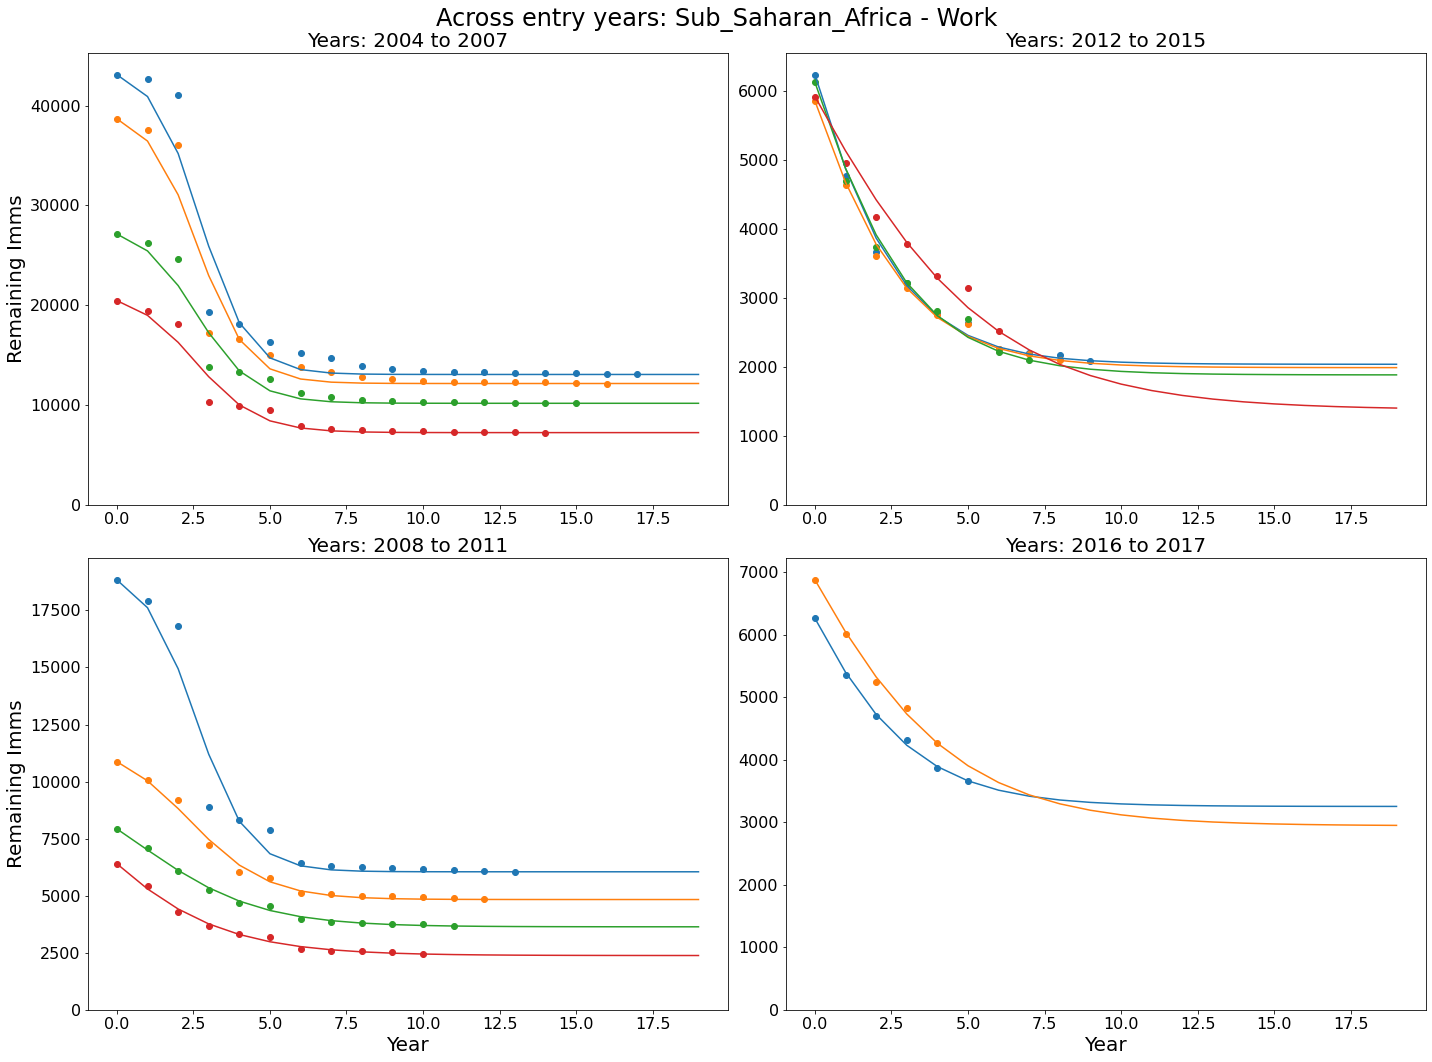

In [18]:
country = 'Sub_Saharan_Africa'
visa = 'Work'
timeSpan = np.array(range(20))

fig, ax = plt.subplots(ncols=2, nrows=2) 

startYear = 2004
endYear = 2008
maxY = 0
for i in range(startYear, endYear):
    plot_data, MLE_values, d_dict = getLogisticFit(country,visa, i) 
    # create extrapolated soln...
    p = MLE_values[0]
    k = MLE_values[1]
    delta = MLE_values[2]
    s_curve = [0.5*(1-np.tanh(k*(i-delta)/2)) for i in timeSpan]
    theory = (p + (1-p)*np.array(s_curve)/s_curve[0])*plot_data['Data'].values[0]
    ax[0, 0].plot(timeSpan, theory)
    ax[0, 0].scatter(plot_data['Year'], plot_data['Data'])
    maxY = max(maxY, max(plot_data['Data']))

title = f'Years: {startYear} to {endYear-1}'
ax[0, 0].set_title(title, fontsize=20)
ax[0, 0].tick_params(axis='both', which='major', labelsize=16)
ax[0, 0].set_ylim(0, maxY*1.05)

startYear = 2008
endYear = 2012
maxY = 0
for i in range(startYear, endYear):
    plot_data, MLE_values, d_dict = getLogisticFit(country,visa, i) 
    # create extrapolated soln... 
    p = MLE_values[0]
    k = MLE_values[1]
    delta = MLE_values[2]
    s_curve = [0.5*(1-np.tanh(k*(i-delta)/2)) for i in timeSpan]
    theory = (p + (1-p)*np.array(s_curve)/s_curve[0])*plot_data['Data'].values[0]
    ax[1, 0].plot(timeSpan, theory)
    ax[1, 0].scatter(plot_data['Year'], plot_data['Data'])
    maxY = max(maxY, max(plot_data['Data']))

title = f'Years: {startYear} to {endYear-1}'
ax[1, 0].set_title(title, fontsize=20)
ax[1, 0].tick_params(axis='both', which='major', labelsize=16)
ax[1, 0].set_ylim(0, maxY*1.05)


startYear = 2012
endYear = 2016
maxY = 0
for i in range(startYear, endYear):
    plot_data, MLE_values, d_dict = getLogisticFit(country, visa, i) 
    # create extrapolated soln...
    p = MLE_values[0]
    k = MLE_values[1]
    delta = MLE_values[2]
    s_curve = [0.5*(1-np.tanh(k*(i-delta)/2)) for i in timeSpan]
    theory = (p + (1-p)*np.array(s_curve)/s_curve[0])*plot_data['Data'].values[0]
    ax[0, 1].plot(timeSpan, theory)
    ax[0, 1].scatter(plot_data['Year'], plot_data['Data'])
    maxY = max(maxY, max(plot_data['Data']))

title = f'Years: {startYear} to {endYear-1}'
ax[0, 1].set_title(title, fontsize=20)
ax[0, 1].tick_params(axis='both', which='major', labelsize=16)
ax[0, 1].set_ylim(0, maxY*1.05)


startYear = 2016
endYear = 2018
maxY = 0
for i in range(startYear, endYear):
    plot_data, MLE_values, d_dict = getLogisticFit(country,visa, i) 
    # create extrapolated soln...
    p = MLE_values[0]
    k = MLE_values[1]
    delta = MLE_values[2]
    s_curve = [0.5*(1-np.tanh(k*(i-delta)/2)) for i in timeSpan]
    theory = (p + (1-p)*np.array(s_curve)/s_curve[0])*plot_data['Data'].values[0]
    ax[1, 1].plot(timeSpan, theory)
    ax[1, 1].scatter(plot_data['Year'], plot_data['Data'])
    maxY = max(maxY, max(plot_data['Data']))

title = f'Years: {startYear} to {endYear-1}'
ax[1, 1].set_title(title, fontsize=20)
ax[1, 1].tick_params(axis='both', which='major', labelsize=16)
ax[1, 1].set_ylim(0, maxY*1.05)

ax[0, 0].set_ylabel('Remaining Imms', fontsize=20)
ax[1, 0].set_ylabel('Remaining Imms', fontsize=20)
ax[1, 0].set_xlabel(xlabel='Year', fontsize=20)
ax[1, 1].set_xlabel(xlabel='Year', fontsize=20)

fig.set_size_inches(20, 15)
fig.suptitle(f'Across entry years: {country} - {visa}', fontsize=24)
fig.tight_layout()
plt.show()

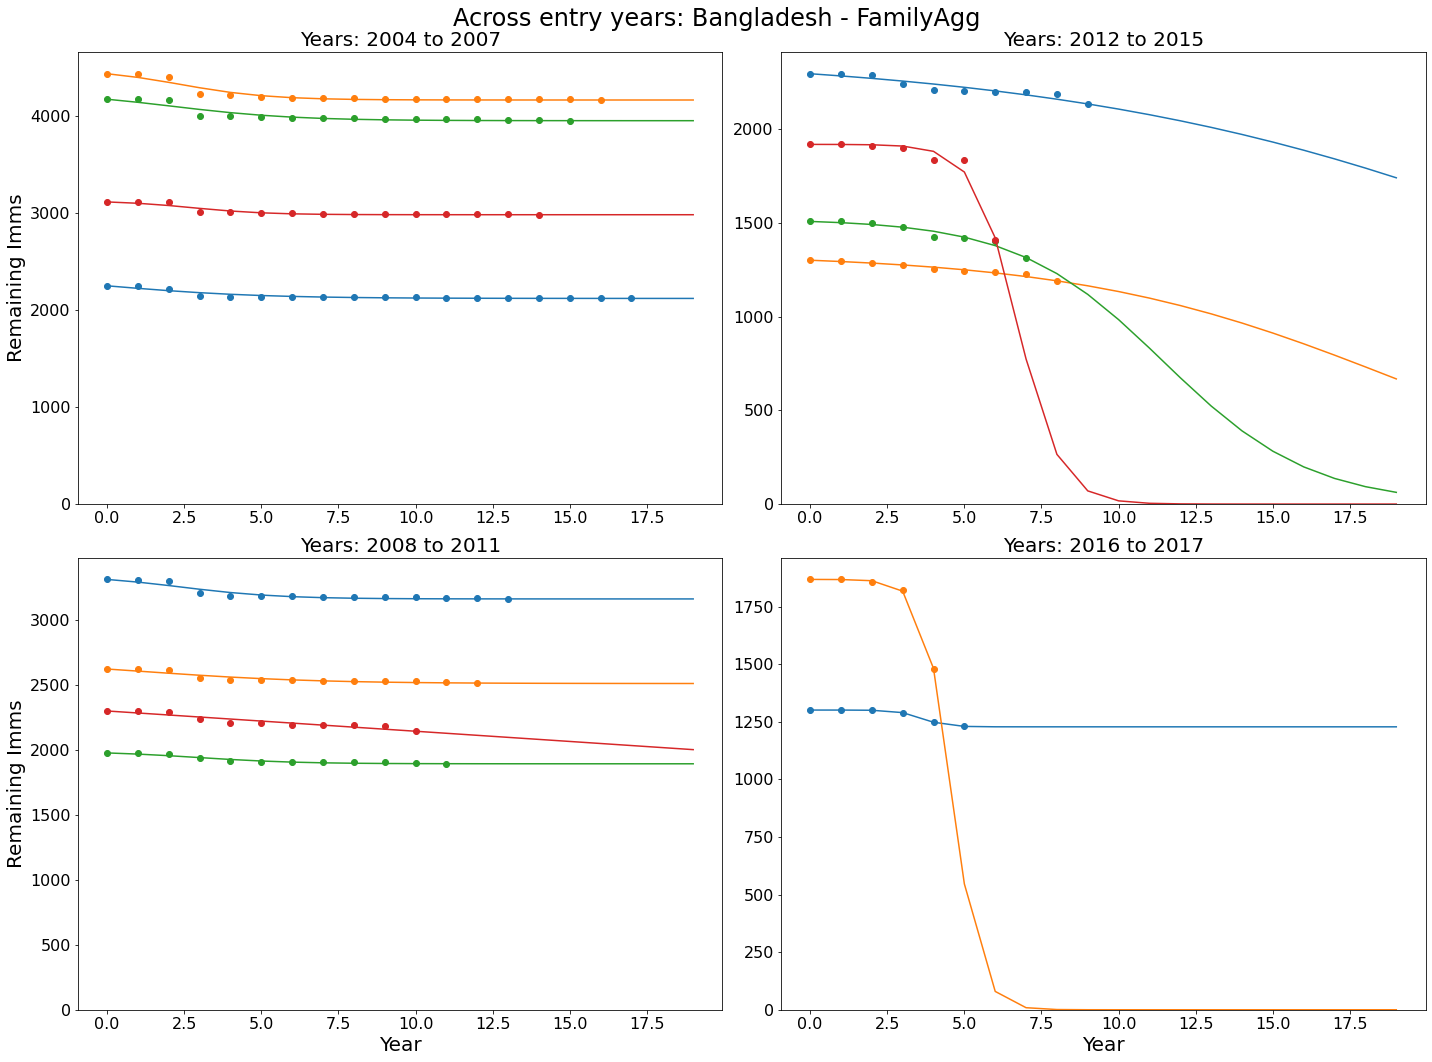

In [19]:
country = 'Bangladesh'
visa = 'FamilyAgg'
timeSpan = np.array(range(20))

fig, ax = plt.subplots(ncols=2, nrows=2) 

startYear = 2004
endYear = 2008
maxY = 0
for i in range(startYear, endYear):
    plot_data, MLE_values, d_dict = getLogisticFit(country,visa, i) 
    # create extrapolated soln...
    p = MLE_values[0]
    k = MLE_values[1]
    delta = MLE_values[2]
    s_curve = [0.5*(1-np.tanh(k*(i-delta)/2)) for i in timeSpan]
    theory = (p + (1-p)*np.array(s_curve)/s_curve[0])*plot_data['Data'].values[0]
    ax[0, 0].plot(timeSpan, theory)
    ax[0, 0].scatter(plot_data['Year'], plot_data['Data'])
    maxY = max(maxY, max(plot_data['Data']))

title = f'Years: {startYear} to {endYear-1}'
ax[0, 0].set_title(title, fontsize=20)
ax[0, 0].tick_params(axis='both', which='major', labelsize=16)
ax[0, 0].set_ylim(0, maxY*1.05)

startYear = 2008
endYear = 2012
maxY = 0
for i in range(startYear, endYear):
    plot_data, MLE_values, d_dict = getLogisticFit(country,visa, i) 
    # create extrapolated soln... 
    p = MLE_values[0]
    k = MLE_values[1]
    delta = MLE_values[2]
    s_curve = [0.5*(1-np.tanh(k*(i-delta)/2)) for i in timeSpan]
    theory = (p + (1-p)*np.array(s_curve)/s_curve[0])*plot_data['Data'].values[0]
    ax[1, 0].plot(timeSpan, theory)
    ax[1, 0].scatter(plot_data['Year'], plot_data['Data'])
    maxY = max(maxY, max(plot_data['Data']))

title = f'Years: {startYear} to {endYear-1}'
ax[1, 0].set_title(title, fontsize=20)
ax[1, 0].tick_params(axis='both', which='major', labelsize=16)
ax[1, 0].set_ylim(0, maxY*1.05)


startYear = 2012
endYear = 2016
maxY = 0
for i in range(startYear, endYear):
    plot_data, MLE_values, d_dict = getLogisticFit(country, visa, i) 
    # create extrapolated soln...
    p = MLE_values[0]
    k = MLE_values[1]
    delta = MLE_values[2]
    s_curve = [0.5*(1-np.tanh(k*(i-delta)/2)) for i in timeSpan]
    theory = (p + (1-p)*np.array(s_curve)/s_curve[0])*plot_data['Data'].values[0]
    ax[0, 1].plot(timeSpan, theory)
    ax[0, 1].scatter(plot_data['Year'], plot_data['Data'])
    maxY = max(maxY, max(plot_data['Data']))

title = f'Years: {startYear} to {endYear-1}'
ax[0, 1].set_title(title, fontsize=20)
ax[0, 1].tick_params(axis='both', which='major', labelsize=16)
ax[0, 1].set_ylim(0, maxY*1.05)


startYear = 2016
endYear = 2018
maxY = 0
for i in range(startYear, endYear):
    plot_data, MLE_values, d_dict = getLogisticFit(country,visa, i) 
    # create extrapolated soln...
    p = MLE_values[0]
    k = MLE_values[1]
    delta = MLE_values[2]
    s_curve = [0.5*(1-np.tanh(k*(i-delta)/2)) for i in timeSpan]
    theory = (p + (1-p)*np.array(s_curve)/s_curve[0])*plot_data['Data'].values[0]
    ax[1, 1].plot(timeSpan, theory)
    ax[1, 1].scatter(plot_data['Year'], plot_data['Data'])
    maxY = max(maxY, max(plot_data['Data']))

title = f'Years: {startYear} to {endYear-1}'
ax[1, 1].set_title(title, fontsize=20)
ax[1, 1].tick_params(axis='both', which='major', labelsize=16)
ax[1, 1].set_ylim(0, maxY*1.05)

ax[0, 0].set_ylabel('Remaining Imms', fontsize=20)
ax[1, 0].set_ylabel('Remaining Imms', fontsize=20)
ax[1, 0].set_xlabel(xlabel='Year', fontsize=20)
ax[1, 1].set_xlabel(xlabel='Year', fontsize=20)

fig.set_size_inches(20, 15)
fig.suptitle(f'Across entry years: {country} - {visa}', fontsize=24)
fig.tight_layout()
plt.show()

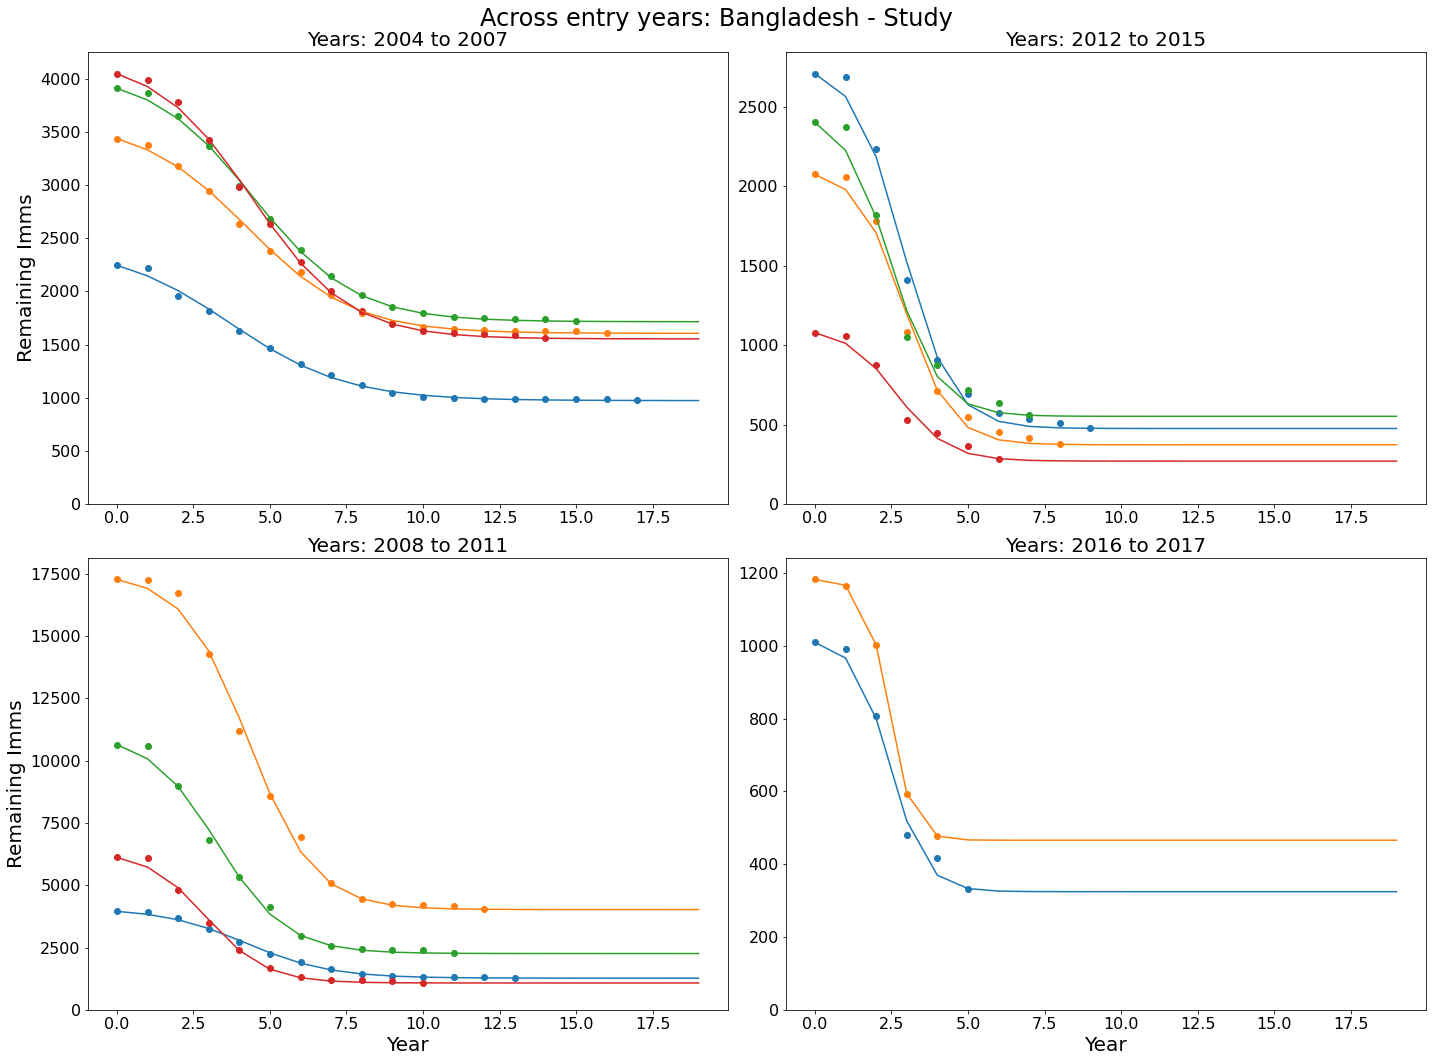

In [20]:
country = 'Bangladesh'
visa = 'Study'
timeSpan = np.array(range(20))

fig, ax = plt.subplots(ncols=2, nrows=2) 

startYear = 2004
endYear = 2008
maxY = 0
for i in range(startYear, endYear):
    plot_data, MLE_values, d_dict = getLogisticFit(country,visa, i) 
    # create extrapolated soln...
    p = MLE_values[0]
    k = MLE_values[1]
    delta = MLE_values[2]
    s_curve = [0.5*(1-np.tanh(k*(i-delta)/2)) for i in timeSpan]
    theory = (p + (1-p)*np.array(s_curve)/s_curve[0])*plot_data['Data'].values[0]
    ax[0, 0].plot(timeSpan, theory)
    ax[0, 0].scatter(plot_data['Year'], plot_data['Data'])
    maxY = max(maxY, max(plot_data['Data']))

title = f'Years: {startYear} to {endYear-1}'
ax[0, 0].set_title(title, fontsize=20)
ax[0, 0].tick_params(axis='both', which='major', labelsize=16)
ax[0, 0].set_ylim(0, maxY*1.05)

startYear = 2008
endYear = 2012
maxY = 0
for i in range(startYear, endYear):
    plot_data, MLE_values, d_dict = getLogisticFit(country,visa, i) 
    # create extrapolated soln... 
    p = MLE_values[0]
    k = MLE_values[1]
    delta = MLE_values[2]
    s_curve = [0.5*(1-np.tanh(k*(i-delta)/2)) for i in timeSpan]
    theory = (p + (1-p)*np.array(s_curve)/s_curve[0])*plot_data['Data'].values[0]
    ax[1, 0].plot(timeSpan, theory)
    ax[1, 0].scatter(plot_data['Year'], plot_data['Data'])
    maxY = max(maxY, max(plot_data['Data']))

title = f'Years: {startYear} to {endYear-1}'
ax[1, 0].set_title(title, fontsize=20)
ax[1, 0].tick_params(axis='both', which='major', labelsize=16)
ax[1, 0].set_ylim(0, maxY*1.05)


startYear = 2012
endYear = 2016
maxY = 0
for i in range(startYear, endYear):
    plot_data, MLE_values, d_dict = getLogisticFit(country, visa, i) 
    # create extrapolated soln...
    p = MLE_values[0]
    k = MLE_values[1]
    delta = MLE_values[2]
    s_curve = [0.5*(1-np.tanh(k*(i-delta)/2)) for i in timeSpan]
    theory = (p + (1-p)*np.array(s_curve)/s_curve[0])*plot_data['Data'].values[0]
    ax[0, 1].plot(timeSpan, theory)
    ax[0, 1].scatter(plot_data['Year'], plot_data['Data'])
    maxY = max(maxY, max(plot_data['Data']))

title = f'Years: {startYear} to {endYear-1}'
ax[0, 1].set_title(title, fontsize=20)
ax[0, 1].tick_params(axis='both', which='major', labelsize=16)
ax[0, 1].set_ylim(0, maxY*1.05)


startYear = 2016
endYear = 2018
maxY = 0
for i in range(startYear, endYear):
    plot_data, MLE_values, d_dict = getLogisticFit(country,visa, i) 
    # create extrapolated soln...
    p = MLE_values[0]
    k = MLE_values[1]
    delta = MLE_values[2]
    s_curve = [0.5*(1-np.tanh(k*(i-delta)/2)) for i in timeSpan]
    theory = (p + (1-p)*np.array(s_curve)/s_curve[0])*plot_data['Data'].values[0]
    ax[1, 1].plot(timeSpan, theory)
    ax[1, 1].scatter(plot_data['Year'], plot_data['Data'])
    maxY = max(maxY, max(plot_data['Data']))

title = f'Years: {startYear} to {endYear-1}'
ax[1, 1].set_title(title, fontsize=20)
ax[1, 1].tick_params(axis='both', which='major', labelsize=16)
ax[1, 1].set_ylim(0, maxY*1.05)

ax[0, 0].set_ylabel('Remaining Imms', fontsize=20)
ax[1, 0].set_ylabel('Remaining Imms', fontsize=20)
ax[1, 0].set_xlabel(xlabel='Year', fontsize=20)
ax[1, 1].set_xlabel(xlabel='Year', fontsize=20)

fig.set_size_inches(20, 15)
fig.suptitle(f'Across entry years: {country} - {visa}', fontsize=24)
fig.tight_layout()
plt.show()

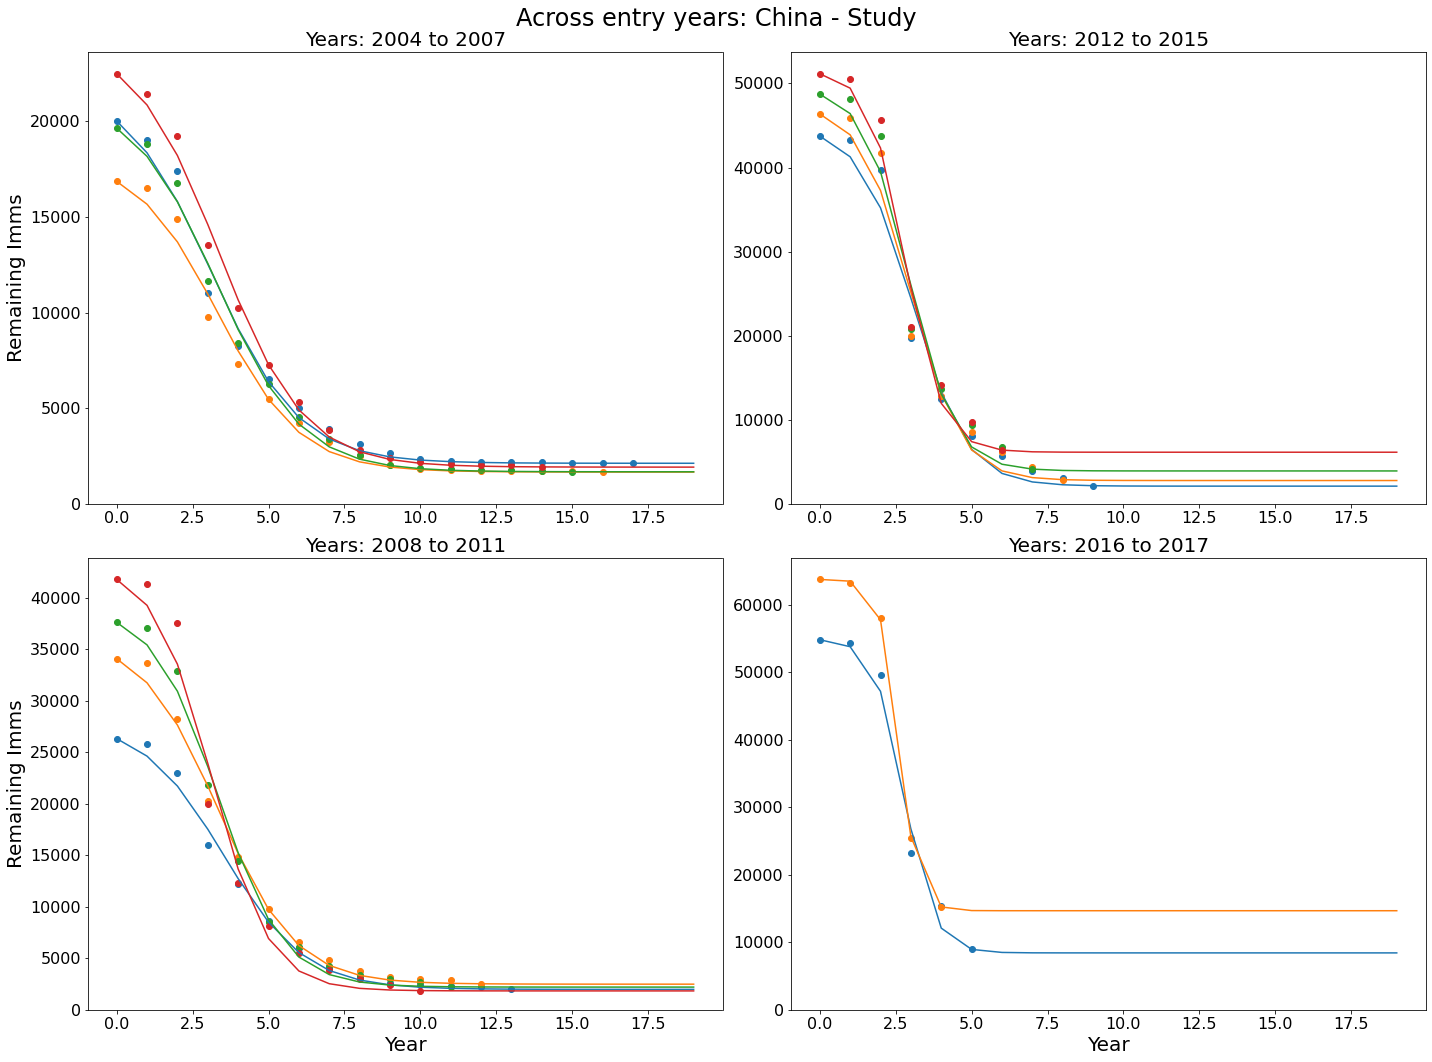

In [21]:
country = 'China'
visa = 'Study'
timeSpan = np.array(range(20))

fig, ax = plt.subplots(ncols=2, nrows=2) 

startYear = 2004
endYear = 2008
maxY = 0
for i in range(startYear, endYear):
    plot_data, MLE_values, d_dict = getLogisticFit(country,visa, i) 
    # create extrapolated soln...
    p = MLE_values[0]
    k = MLE_values[1]
    delta = MLE_values[2]
    s_curve = [0.5*(1-np.tanh(k*(i-delta)/2)) for i in timeSpan]
    theory = (p + (1-p)*np.array(s_curve)/s_curve[0])*plot_data['Data'].values[0]
    ax[0, 0].plot(timeSpan, theory)
    ax[0, 0].scatter(plot_data['Year'], plot_data['Data'])
    maxY = max(maxY, max(plot_data['Data']))

title = f'Years: {startYear} to {endYear-1}'
ax[0, 0].set_title(title, fontsize=20)
ax[0, 0].tick_params(axis='both', which='major', labelsize=16)
ax[0, 0].set_ylim(0, maxY*1.05)

startYear = 2008
endYear = 2012
maxY = 0
for i in range(startYear, endYear):
    plot_data, MLE_values, d_dict = getLogisticFit(country,visa, i) 
    # create extrapolated soln... 
    p = MLE_values[0]
    k = MLE_values[1]
    delta = MLE_values[2]
    s_curve = [0.5*(1-np.tanh(k*(i-delta)/2)) for i in timeSpan]
    theory = (p + (1-p)*np.array(s_curve)/s_curve[0])*plot_data['Data'].values[0]
    ax[1, 0].plot(timeSpan, theory)
    ax[1, 0].scatter(plot_data['Year'], plot_data['Data'])
    maxY = max(maxY, max(plot_data['Data']))

title = f'Years: {startYear} to {endYear-1}'
ax[1, 0].set_title(title, fontsize=20)
ax[1, 0].tick_params(axis='both', which='major', labelsize=16)
ax[1, 0].set_ylim(0, maxY*1.05)


startYear = 2012
endYear = 2016
maxY = 0
for i in range(startYear, endYear):
    plot_data, MLE_values, d_dict = getLogisticFit(country, visa, i) 
    # create extrapolated soln...
    p = MLE_values[0]
    k = MLE_values[1]
    delta = MLE_values[2]
    s_curve = [0.5*(1-np.tanh(k*(i-delta)/2)) for i in timeSpan]
    theory = (p + (1-p)*np.array(s_curve)/s_curve[0])*plot_data['Data'].values[0]
    ax[0, 1].plot(timeSpan, theory)
    ax[0, 1].scatter(plot_data['Year'], plot_data['Data'])
    maxY = max(maxY, max(plot_data['Data']))

title = f'Years: {startYear} to {endYear-1}'
ax[0, 1].set_title(title, fontsize=20)
ax[0, 1].tick_params(axis='both', which='major', labelsize=16)
ax[0, 1].set_ylim(0, maxY*1.05)


startYear = 2016
endYear = 2018
maxY = 0
for i in range(startYear, endYear):
    plot_data, MLE_values, d_dict = getLogisticFit(country,visa, i) 
    # create extrapolated soln...
    p = MLE_values[0]
    k = MLE_values[1]
    delta = MLE_values[2]
    s_curve = [0.5*(1-np.tanh(k*(i-delta)/2)) for i in timeSpan]
    theory = (p + (1-p)*np.array(s_curve)/s_curve[0])*plot_data['Data'].values[0]
    ax[1, 1].plot(timeSpan, theory)
    ax[1, 1].scatter(plot_data['Year'], plot_data['Data'])
    maxY = max(maxY, max(plot_data['Data']))

title = f'Years: {startYear} to {endYear-1}'
ax[1, 1].set_title(title, fontsize=20)
ax[1, 1].tick_params(axis='both', which='major', labelsize=16)
ax[1, 1].set_ylim(0, maxY*1.05)

ax[0, 0].set_ylabel('Remaining Imms', fontsize=20)
ax[1, 0].set_ylabel('Remaining Imms', fontsize=20)
ax[1, 0].set_xlabel(xlabel='Year', fontsize=20)
ax[1, 1].set_xlabel(xlabel='Year', fontsize=20)

fig.set_size_inches(20, 15)
fig.suptitle(f'Across entry years: {country} - {visa}', fontsize=24)
fig.tight_layout()
plt.show()

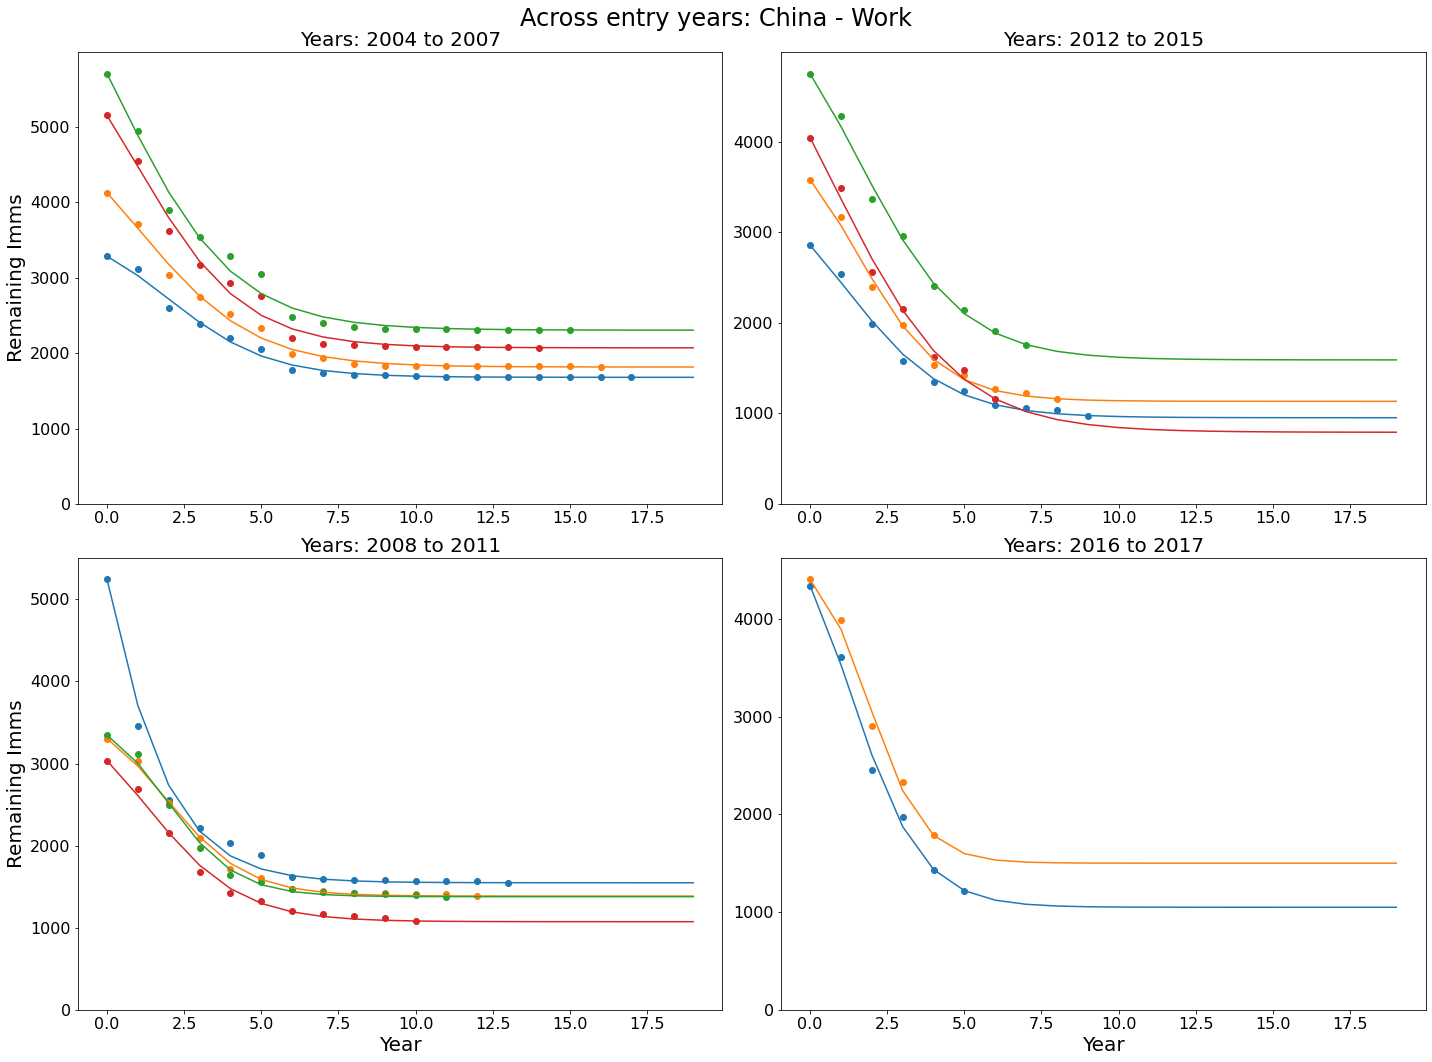

In [22]:
country = 'China'
visa = 'Work'
timeSpan = np.array(range(20))

fig, ax = plt.subplots(ncols=2, nrows=2) 

startYear = 2004
endYear = 2008
maxY = 0
for i in range(startYear, endYear):
    plot_data, MLE_values, d_dict = getLogisticFit(country,visa, i) 
    # create extrapolated soln...
    p = MLE_values[0]
    k = MLE_values[1]
    delta = MLE_values[2]
    s_curve = [0.5*(1-np.tanh(k*(i-delta)/2)) for i in timeSpan]
    theory = (p + (1-p)*np.array(s_curve)/s_curve[0])*plot_data['Data'].values[0]
    ax[0, 0].plot(timeSpan, theory)
    ax[0, 0].scatter(plot_data['Year'], plot_data['Data'])
    maxY = max(maxY, max(plot_data['Data']))

title = f'Years: {startYear} to {endYear-1}'
ax[0, 0].set_title(title, fontsize=20)
ax[0, 0].tick_params(axis='both', which='major', labelsize=16)
ax[0, 0].set_ylim(0, maxY*1.05)

startYear = 2008
endYear = 2012
maxY = 0
for i in range(startYear, endYear):
    plot_data, MLE_values, d_dict = getLogisticFit(country,visa, i) 
    # create extrapolated soln... 
    p = MLE_values[0]
    k = MLE_values[1]
    delta = MLE_values[2]
    s_curve = [0.5*(1-np.tanh(k*(i-delta)/2)) for i in timeSpan]
    theory = (p + (1-p)*np.array(s_curve)/s_curve[0])*plot_data['Data'].values[0]
    ax[1, 0].plot(timeSpan, theory)
    ax[1, 0].scatter(plot_data['Year'], plot_data['Data'])
    maxY = max(maxY, max(plot_data['Data']))

title = f'Years: {startYear} to {endYear-1}'
ax[1, 0].set_title(title, fontsize=20)
ax[1, 0].tick_params(axis='both', which='major', labelsize=16)
ax[1, 0].set_ylim(0, maxY*1.05)


startYear = 2012
endYear = 2016
maxY = 0
for i in range(startYear, endYear):
    plot_data, MLE_values, d_dict = getLogisticFit(country, visa, i) 
    # create extrapolated soln...
    p = MLE_values[0]
    k = MLE_values[1]
    delta = MLE_values[2]
    s_curve = [0.5*(1-np.tanh(k*(i-delta)/2)) for i in timeSpan]
    theory = (p + (1-p)*np.array(s_curve)/s_curve[0])*plot_data['Data'].values[0]
    ax[0, 1].plot(timeSpan, theory)
    ax[0, 1].scatter(plot_data['Year'], plot_data['Data'])
    maxY = max(maxY, max(plot_data['Data']))

title = f'Years: {startYear} to {endYear-1}'
ax[0, 1].set_title(title, fontsize=20)
ax[0, 1].tick_params(axis='both', which='major', labelsize=16)
ax[0, 1].set_ylim(0, maxY*1.05)


startYear = 2016
endYear = 2018
maxY = 0
for i in range(startYear, endYear):
    plot_data, MLE_values, d_dict = getLogisticFit(country,visa, i) 
    # create extrapolated soln...
    p = MLE_values[0]
    k = MLE_values[1]
    delta = MLE_values[2]
    s_curve = [0.5*(1-np.tanh(k*(i-delta)/2)) for i in timeSpan]
    theory = (p + (1-p)*np.array(s_curve)/s_curve[0])*plot_data['Data'].values[0]
    ax[1, 1].plot(timeSpan, theory)
    ax[1, 1].scatter(plot_data['Year'], plot_data['Data'])
    maxY = max(maxY, max(plot_data['Data']))

title = f'Years: {startYear} to {endYear-1}'
ax[1, 1].set_title(title, fontsize=20)
ax[1, 1].tick_params(axis='both', which='major', labelsize=16)
ax[1, 1].set_ylim(0, maxY*1.05)

ax[0, 0].set_ylabel('Remaining Imms', fontsize=20)
ax[1, 0].set_ylabel('Remaining Imms', fontsize=20)
ax[1, 0].set_xlabel(xlabel='Year', fontsize=20)
ax[1, 1].set_xlabel(xlabel='Year', fontsize=20)

fig.set_size_inches(20, 15)
fig.suptitle(f'Across entry years: {country} - {visa}', fontsize=24)
fig.tight_layout()
plt.show()

Below is the distribution of times to 99.5% re-immigration across all fitted emigration models. Apart from the outlier at 75ish, the maximum is now less than 20 years. This reduction can be reflected in the IBM code with a reduced number of years of stored history.  

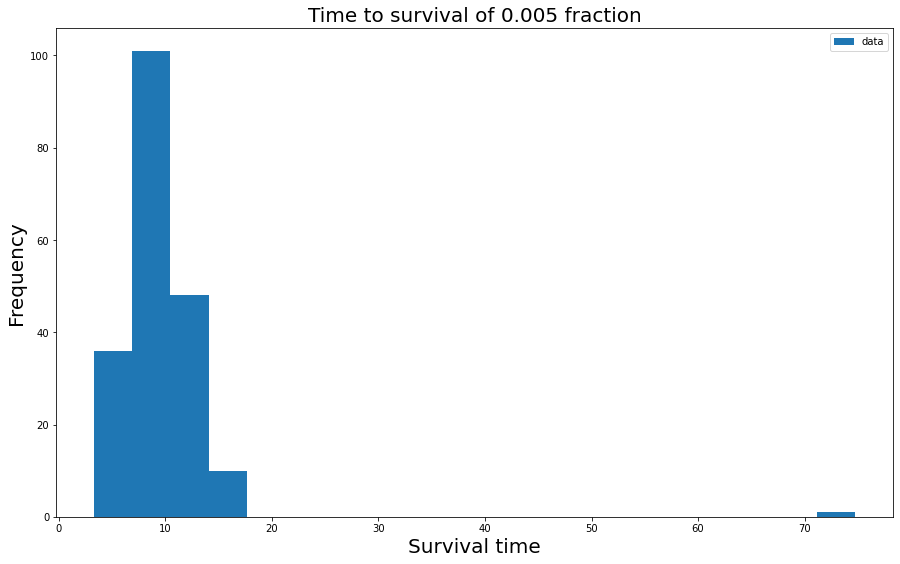

In [23]:
# Read in the valid parameters file created in the previous cell. 
np.random.seed(1)
# paramFileName = 'MJ_InfluxSurvival3.txt'  # was ...2.txt
paramFileName = encPath + f'MJ_InfluxSurvival_{Encoding}.txt'

modelParam_data = pd.read_csv(paramFileName, sep='\t')
# we rely on the order, so reorder.
modCols = list(modelParam_data.columns)
modelParam_data.sort_values(by=modCols[:-1], inplace=True)
modelSize = 4   # number of params stored for each model.
lenData = modelParam_data.shape[0]
nModels = lenData//modelSize

# How long to get to 0.5% survival for re-emigrating population?
resIndex = 0
minFracSurvival = 0.005
maxStore = np.zeros(nModels)

for i in range(nModels):
    currentIndex = i*modelSize
    # Is the model Kosher?
    currentMLEs = modelParam_data['Value'].values[currentIndex:currentIndex+3]
    badModel = currentMLEs[0] < 0
    if badModel:
        continue  # if it's a dud model, go to next.

    maxStore[resIndex] = currentMLEs[2] - np.log(minFracSurvival)/currentMLEs[1]

    resIndex += 1


data_dict = {'data': maxStore[:resIndex]}
plot_df = pd.DataFrame(data_dict)

fig, currentAx = plt.subplots()

plot_df.plot.hist(bins=20, ax=currentAx)
title = f'Time to survival of {minFracSurvival} fraction'
currentAx.set_title(title, fontsize=20)
x_label = 'Survival time'
currentAx.set_xlabel(x_label, fontsize=20)
currentAx.set_ylabel('Frequency', fontsize=20)

fig.set_size_inches(15, 9)
# fig.tight_layout()

plt.show()

## Dependencies
The following files are needed by this notebook: 
 - **migrant_journey_updatedSep21_e.csv**: data file from Laura, cleaned up. 
 - **requirements.txt**: Needed if using binder to render the notebook. See below.  
The file below are in the **SharedFiles** folder:
 - **DefEncoding_4visa.p**: pickled encoding dictionaries for the 4-visa setup.
 - **DefEncoding_3v6c.p**: pickled encoding dictionaries for the 3v5c setup.
 - **MJ_InfluxSurvival_4visa.txt**: Survival model parameters for the 4-visa setup.
 - **MJ_InfluxSurvival_3v6c.txt**: Survival model parameters for the 3v5c setup.
 
The folowing information is required by binder and needs to be copied into the requirements.txt file. 

In [24]:
%load_ext watermark

%watermark -v -n -p numpy,pandas,scipy,matplotlib,watermark,emcee


Python implementation: CPython
Python version       : 3.9.4
IPython version      : 7.22.0

numpy     : 1.20.2+mkl
pandas    : 1.2.4
scipy     : 1.6.2
matplotlib: 3.4.1
watermark : 2.2.0
emcee     : 3.0.2

